# DSC511 Group Project: Hotel Review Sentiment Analysis and Rating Prediction

## Authors

- Maria Tsilidou
- Anastasios Nikodimou
- Ioannis Demetriou

## Abstract

In the era of digital transformation, online hotel reviews have become a significant factor in
shaping travelers' booking decisions. Reviews provide firsthand experiences from guests,
offering insights into hotel quality, customer satisfaction, and areas of improvement. Using
data collection, aggregation and processing techniques we seek to formulate and answer
questions related to hotel ratings, customer sentiment, and prediction modeling.

TODO LIST

- EDA (Exploratory Data Analysis)
- Περισσότερα γραφήματα για κείμενα (π.χ. κατανομές tokens, μέσος όρος λέξεων ανά κείμενο)
- Plots με αριθμό tokens, κατανομή, μέσους όρους κτλ.
- Machine Learning / NLP tasks
- Χρήση περισσότερων αλγορίθμων για ταξινόμηση κειμένου.
- Επεξεργασία κειμένου:
- Lemmatization + Tokenization: εύρεση ποια tokens εμφανίζονται πιο συχνά.
- Classification of Reviews:
- Δοκιμή σε υπάρχοντα reviews αν τα ταξινομεί σωστά ως θετικά ή αρνητικά.
- Δημιουργία δικών μας reviews και δοκιμή ταξινόμησης (π.χ. με χρήση KNN βάσει tokens).
- Bias Analysis
- Έλεγχος για bias στα δεδομένα ή στο μοντέλο (π.χ. imbalance στα labels).
- Scaling / Preprocessing
- Δοκιμή scalers (π.χ. MaxMinScaler) σε NLP χαρακτηριστικά (όπως TF-IDF values).
- Recommendation System
- Ανάπτυξη Hybrid Recommendation System:
- Συνδυασμός content-based και collaborative filtering μεθόδων.
- Να γίνει προσεκτική και σωστή υλοποίηση.
 - Clarify how we plan to interpret the `Additional_Number_of_Scoring` variable.

In [ ]:
# Importing libraries

import folium
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import os
import seaborn as sns
import pandas as pd

from nltk.stem import WordNetLemmatizer

from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    MultilayerPerceptronClassifier,
    LogisticRegression,
    RandomForestClassifier,
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import (
    ClusteringEvaluator,
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
    RegressionEvaluator,
)
from pyspark.ml.feature import (
    HashingTF,
    IDF,
    NGram,
    RegexTokenizer,
    StopWordsRemover,
    StringIndexer,
    PCA,
    Tokenizer,
    VectorAssembler,
)
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import(
    avg,
    array,
    array_contains,
    col,
    concat_ws,
    count,
    isnan,
    isnull,
    length,
    lit,
    lower,
    mean,
    regexp_replace,
    size,
    skewness,
    split,
    to_date,
    trim,
    udf,
    when,
)
from pyspark.sql.types import ArrayType, BooleanType, FloatType, IntegerType, StringType

sns.set_palette("viridis")
spark = SparkSession.builder.appName("DSC511-GroupProject").master("local[*]").config("spark.driver.memory", "10g").getOrCreate()

## Dataset

The analysis will use the "515k Hotel Reviews Data in Europe" dataset obtained from
[here](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe)
at the time of writing. It contains over 500k reviews, scraped from Booking.com, scoring
1493 luxury hotels across Europe. Each review includes 17 features, including textual
feedback and scoring, reviewer nationality, hotel location, providing diverse data types for
analysis.

In this section we will load and inspect the dataset, clean it if necessary, and
prepare it for analysis by casting to appropriate types and other feature engineering.

In [ ]:
# Loading dataset

# Here we took advantage of spark's ability to understand files compressed with gzip
# and we added the dataset in a `.csv.gz` form.

# Note: inferSchema=True is "expensive". Consider removing it for performance if needed
# Consider fitting the once deduced `original_schema` while re-running this

original = spark.read.csv('./data/Hotel_Reviews.csv.gz', header=True, inferSchema=True)
original_schema = original.schema

In [1]:
# Getting an idea about the dataset's shape
original_count = original.count()
print(f'Number of observations: {original_count}')
print(f'Number of features: {len(original_schema)}')

Number of observations: 515738
Number of features: 17


### Understanding the dataset

The dataset appears to be the "exploded" join of a hotel, reviewer and review table. In particular,

Hotel:

- `Hotel_Name`: Name of Hotel
- `Hotel_Address`: Address of hotel.
- `lat`: Latitude of the hotel
- `lng`: longtitude of the hotel
- `Average_Score`: Average Score of the hotel, calculated based on the latest comment in the last year.
- `Total_Number_of_Reviews`: Total number of valid reviews the hotel has.

Reviewer:

- `Reviewer_Nationality`: Nationality of Reviewer
- `Total_Number_of_Reviews_Reviewer_Has_Given`: Number of Reviews the reviewers has given in the past.

Review:

- `Review_Date`: Date when reviewer posted the corresponding review.
- `Negative_Review`: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- `Review_Total_Negative_Word_Counts`: Total number of words in the negative review.
- `Positive_Review`: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
- `Review_Total_Positive_Word_Counts`: Total number of words in the positive review.
- `Reviewer_Score`: Score the reviewer has given to the hotel, based on his/her experience
- `Tags`: Tags reviewer gave the hotel.
- `days_since_review`: Duration between the review date and scrape date.
- `Additional_Number_of_Scoring`: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.

In [2]:
# We visualize the first entries in order to decide our next steps

original.printSchema()

original.select(
    'Hotel_Name', 'Reviewer_Nationality',
    'Review_Date', 'Negative_Review', 'Positive_Review', 'Tags', 'days_since_review'
    ).show(5, truncate=15)

root
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Positive_Review: string (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)

+-----------+--------------------+-----------+---------------+---------------+---------------+-----------------+
| Hotel_Name|Reviewer_Nationality|R

### Cleaning the dataset

We want to check the quality of our dataset. In this first interaction with the
dataset we will:

- Check if there are missing values, and mark them as such.
- Check if there are duplicate entries, and drop them.
- Check if there are obvious erroneous entries, and remove them.
- Convert, where appropriate, data in a format easier for Spark to process.

In [ ]:
cleaned = original # Keep a copy of original dataset for comparisons

In [ ]:
# The dataset is very big, and as we progress we would need a way to speed up
# our computations

def persist(name, df=cleaned):
    df.persist()
    df.write.mode("overwrite").parquet(f'./data/checkpoint-{name}')


def restore(name):
    return spark.read.parquet(f'./data/checkpoint-{name}')

In [ ]:
# CHECKPOINT 0

if True:
    persist('0-original')
else:
    cleaned = restore('0-original')

In [3]:
# Counting nulls in each column
missing_counts = cleaned.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in cleaned.columns])
missing_counts.toPandas().T

# There are empty values in the dataset but the are not shown below

                                            0
Hotel_Address                               0
Additional_Number_of_Scoring                0
Review_Date                                 0
Average_Score                               0
Hotel_Name                                  0
Reviewer_Nationality                        0
Negative_Review                             0
Review_Total_Negative_Word_Counts           0
Total_Number_of_Reviews                     0
Positive_Review                             0
Review_Total_Positive_Word_Counts           0
Total_Number_of_Reviews_Reviewer_Has_Given  0
Reviewer_Score                              0
Tags                                        0
days_since_review                           0
lat                                         0
lng                                         0

Our dataset contains empty values that are not treated as null. This could be because
there are empty strings and not null values or they might contain white space
characters. We will replace the empty string with null so that Spark recognizes it
and treats it as a missing value.

In [4]:
# Replacing empty strings with Spark's null
for c in cleaned.columns:
    cleaned = cleaned.withColumn(c, when(trim(col(c)) == '', None).otherwise(col(c)))

# Re-running the previous code to check whether the empty strings got indeed converted to null
missing_counts = cleaned.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in cleaned.columns])
missing_counts.toPandas().T

                                              0
Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                        523
Negative_Review                             849
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                             183
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Tags                                          0
days_since_review                             0
lat                                           0
lng                                           0

The `Reviewer_Nationality`, `Negative_Review` and `Positive_Review` columns contain
null values that spark can identify.

Empty strings is not the only "not-null" null values a string can have.
In many datasets missing values can be represented as 'NA' (a string) instead of null.
Spark won’t treat 'NA' as a missing value unless we explicitly handle it.
So if we're only checking for null, we might miss those 'not-null nulls'.
This is why we need to check each column for the presence of 'not-null' nulls.

The following code-snippet counts the 'not-null' nulls in our dataset.

In [5]:
fake_nulls = ['NA', 'N/A', 'na', 'n/a', 'null', 'None', ' N A', ' n a', ' N a']

not_null_nulls = []

# Loop through columns and count not-null nulls in each
for column in cleaned.columns:
    num_fake_nulls = cleaned.select(
        F.sum(when(col(column).isin(fake_nulls), 1).otherwise(0)).alias("not_null_nulls")
    ).collect()[0]["not_null_nulls"]

    if num_fake_nulls > 0:
        not_null_nulls.append((column, num_fake_nulls))

# Display the result
spark.createDataFrame(not_null_nulls, ["column", "not_null_nulls"]).show(truncate=False)

+---------------+--------------+
|column         |not_null_nulls|
+---------------+--------------+
|Negative_Review|1773          |
|Positive_Review|53            |
|lat            |3268          |
|lng            |3268          |
+---------------+--------------+



In [ ]:
cleaned = cleaned\
    .withColumn(
        'Negative_Review',
        trim(col('Negative_Review'))
    )\
    .withColumn(
        'Negative_Review',
        when(col('Negative_Review').isin(fake_nulls), lit(None) ).otherwise((col('Negative_Review')))
    )\
    .withColumn(
        'Positive_Review',
        trim(col('Positive_Review'))
    )\
    .withColumn(
        'Positive_Review',
        when(col('Positive_Review').isin(fake_nulls), lit(None) ).otherwise((col('Positive_Review')))
    )

The reviews and coordinates contain values that should be marked as NULL.

According to the dataset description, we expect `No Negative` in the `Negative_Review`
column instead of a `NULL` and a `No Positive` in the `Positive_Review` column.

Further processing of the reviews will take place in the NLP section.

In [6]:
# According to the dataset, the absence of positive / negative reviews is expressed as 'No Positive' / 'No Negative'
cleaned = cleaned\
    .withColumn(
        'Negative_Review',
        when(col('Negative_Review') == 'No Negative', lit(None)).otherwise(col('Negative_Review'))
    ).withColumn(
        'Positive_Review',
        when(col('Positive_Review') == 'No Positive', lit(None)).otherwise(col('Positive_Review'))
    )

# Verify
cleaned.select('Negative_Review', 'Positive_Review').show()

+--------------------+--------------------+
|     Negative_Review|     Positive_Review|
+--------------------+--------------------+
|I am so angry tha...|Only the park out...|
|                NULL|No real complaint...|
|Rooms are nice bu...|Location was good...|
|My room was dirty...|Great location in...|
|You When I booked...|Amazing location ...|
|Backyard of the h...|Good restaurant w...|
|Cleaner did not c...|The room is spaci...|
|Apart from the pr...|Good location Set...|
|Even though the p...|                NULL|
|The aircondition ...|The room was big ...|
|   Nothing all great|Rooms were stunni...|
|6 30 AM started b...|Style location rooms|
|The floor in my r...|Comfy bed good lo...|
|                NULL|This hotel is bei...|
|The staff in the ...|It was very good ...|
|                NULL|This hotel is awe...|
|Very steep steps ...|Great onsite cafe...|
|We did not like t...|We loved the loca...|
|                NULL|Public areas are ...|
|We had issues wit...|I liked th

In [7]:
# Checking for duplicates
cleaned = cleaned.drop_duplicates()

print(f'From our dataset, {cleaned.count()} / {original.count()} are distinct')

From our dataset, 515212 / 515738 are distinct


### Type casting the dataset

We now inspect the schema and encoding of our features. We want to cast the data
into a format that will be easier to process.

From the schema and the first few observations, we see that we can benefit
from casting to more python friendly instances, or categorical features that
can be encoded as such.

In [8]:
# We notice that lon/lat represented here as decimal degrees should be numeric,
# but they are typed as strings. This could mean that there are some "hard-coded" NAs

print('Hotels with missing coordinates')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(~col('lng').rlike(r'[0-9]') | ~col('lat').rlike(r'[0-9]'))\
    .distinct()\
    .show(truncate=False)

# It seems that 'NA' is `None`. Let's update it
cleaned = cleaned\
    .withColumn(
        'lng',
        when(col('lng') == 'NA', lit(None)).otherwise(col('lng'))
    ).withColumn(
        'lat',
        when(col('lat') == 'NA', lit(None)).otherwise(col('lat'))
    ).withColumn(
        'lng',
        col('lng').cast(FloatType())
    ).withColumn(
        'lat',
        col('lat').cast(FloatType())
    )

# Verify
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(~col('lng').rlike(r'[0-9]') | ~col('lat').rlike(r'[0-9]') | col('lng').isNull() | col('lat').isNull())\
    .distinct()\
    .show(truncate=False)

# Entries with missing lon/lat
print('Number of reviews with missing coordinates:')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(col('lng').isNull() | col('lat').isNull())\
    .count()

Hotels with missing coordinates
+-----------------------------------------------------------+---+---+
|Hotel_Address                                              |lng|lat|
+-----------------------------------------------------------+---+---+
|4 rue de la P pini re 8th arr 75008 Paris France           |NA |NA |
|Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria   |NA |NA |
|Paragonstra e 1 11 Simmering 1110 Vienna Austria           |NA |NA |
|20 Rue De La Ga t 14th arr 75014 Paris France              |NA |NA |
|W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria   |NA |NA |
|Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria        |NA |NA |
|Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria     |NA |NA |
|Pau Clar s 122 Eixample 08009 Barcelona Spain              |NA |NA |
|Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria|NA |NA |
|Hasenauerstra e 12 19 D bling 1190 Vienna Austria          |NA |NA |
|Savoyenstra e 2 16 Ottakring 1160 Vienna Austria         

3268

The `Hotel_Address` seems to have no missing data. We conclude this by testing if the
length of the string is less than a reasonable address size and if there is any
`None` values.

In [9]:
print('Hotel Addresses with None entries:')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(col('Hotel_Address').isNull() )\
    .count()

print('Hotel Addresses with invalid addresses:')
cleaned\
    .select('Hotel_Address', 'lng', 'lat')\
    .filter(length(col('Hotel_Address')) < 10 )\
    .count()

Hotel Addresses with None entries:
Hotel Addresses with invalid addresses:


0

We notice that some of our features are time related, but are typed as strings.

In particular,

- `Review_Date`
- `days_since_review`

We will cast them to datetime and integers (after we confirm the units) respectively

In [10]:
cleaned = cleaned\
    .withColumn('Review_Date', to_date(col('Review_Date'), format='M/d/yyyy'))

# Let's see if it worked
cleaned\
    .select('Review_Date')\
    .show(5)

+-----------+
|Review_Date|
+-----------+
| 2016-05-07|
| 2016-08-01|
| 2016-06-07|
| 2016-05-09|
| 2016-12-14|
+-----------+
only showing top 5 rows



In [11]:
cleaned\
    .select('days_since_review')\
    .show(5)

# We see that the format is "<days> day(s)"

@udf(IntegerType())
def days_ago_udf(literal):
    days, unit = literal.split()
    if not days.isdigit():
        raise RuntimeError(f'Unexpected day: {days}')

    if not unit.startswith('day'):
        raise RuntimeError(f'Unexpected time unit: {unit}')

    try:
        return int(days)
    except Exception as e:
        e.args = (f'An error occurred while processing {literal}: {e}',)
        raise


cleaned = cleaned\
    .withColumn('days_since_review',
        days_ago_udf(col('days_since_review'))
    )

# Admire our result
cleaned\
    .select('days_since_review')\
    .show(5)

+-----------------+
|days_since_review|
+-----------------+
|          453 day|
|          367 day|
|          422 day|
|          451 day|
|          232 day|
+-----------------+
only showing top 5 rows

+-----------------+
|days_since_review|
+-----------------+
|              453|
|              367|
|              422|
|              451|
|              232|
+-----------------+
only showing top 5 rows



### Geospatial

In this section we will enrich our data with additional spacial information.
Even though we have have all the coordinates of the hotels, not all hotels
have address, city or country information.

We can use a reverse geocoding server to retrieve the address of each location.
However, because of rate limiting and API keys restrictions we cannot get all
the addresses of all our dataset. Instead, given the democratization of the
spatial data by OpenStreetMap and other affiliated open source champions, we
can host our own Nominatim instance, download the `country_grid.sql.gz` dataset,
and query for features at the specific location.

Please follow the instructions to start the server.

TL;DR: `make nominatim/build && make nominatim/run`

In [ ]:
def get_connection():
    import psycopg2 # keep it herer - problems with python 3.10

    try:
        return psycopg2.connect(
            database="nominatim",
            user="postgres",
            password="n7m-geocoding",
            host="localhost",
        )
    except:
        return False

def query_country(lon, lat):
    query = f"""
    SELECT DISTINCT country_osm_grid.country_code
        FROM country_osm_grid
        WHERE ST_Contains(country_osm_grid.geometry, ST_GeomFromText('POINT({lon} {lat})', 4326));
    """

    with nominatim:
        with nominatim.cursor() as curr:
            curr.execute(query)
            return curr.fetchone()[0]


@udf(StringType())
def query_country_udf(lon, lat):
    return query_country(lon, lat)

if os.getenv('DSC511-NOMINATIM'):
    nominatim = get_connection()
    cleaned.withColumn('Country', query_country_udf('lng', 'lat'))

    nominatim.close()
else:
    # Load the processed data to save time
    pass

In [12]:
# We source countries.csv from https://developers.google.com/public-data/docs/canonical/countries_csv
countries = pd.read_csv('./data/countries.csv', delimiter='\t').set_index('ISO')
_countries = countries.name.str.upper().to_dict().items()

@udf(StringType())
def extract_country(address):
    for iso, name in _countries:
        if address.upper().endswith(name):
            return iso

cleaned = cleaned\
    .withColumn('Country', extract_country('Hotel_Address'))

# StringIndexer that safely handles nulls and unseen labels
country_indexer = StringIndexer(inputCol='Country', outputCol='Country_Encoded') \
                    .setHandleInvalid("keep")

# Fit and transform
cleaned = country_indexer.fit(cleaned).transform(cleaned)

# Cache the DataFrame in memory to speed up later operations
cleaned.persist()

cleaned\
    .select('Country')\
    .groupBy('Country').count().orderBy("count", ascending=False)\
    .show()

# TODO: Do we need cities as well?

+-------+------+
|Country| count|
+-------+------+
|     GB|262298|
|     ES| 60149|
|     FR| 59413|
|     NL| 57211|
|     AT| 38937|
|     IT| 37204|
+-------+------+



In [13]:
hotels = cleaned\
    .select('Hotel_Name', 'Hotel_Address', 'Average_Score', 'Total_Number_of_Reviews', 'lng', 'lat', 'Country')\
    .distinct()

hotels_df = hotels\
    .filter(~col('lng').isNull() & ~col('lat').isNull())\
    .toPandas()

m = folium.Map(location=[33.5, 35.1], zoom_start=4)

def color_review(score):
    if score >=8.0:
        return 'green'
    elif score >= 6.0:
        return 'orange'
    else:
        return 'red'

# TODO: Add additional features

for index, row in hotels_df.iterrows():
    folium.Marker(
        icon=folium.Icon(color=color_review(row['Average_Score'])),
        location=[row['lat'], row['lng']],
        tooltip=row['Hotel_Name'],
        popup=f'<b>{row["Hotel_Name"]}</b><br>Rating: {row["Average_Score"]}',
    ).add_to(m)

m.save('./results/hotels.html')
m

We notice that the hotels from our dataset come from 6 European cities:

- Vienna, Austria
- Paris, France
- Amsterdam, Netherlands
- Barcelona, Spain
- Milan, Paris
- London, United Kingdom

In [14]:
hotels.groupby('Country').agg(count('*').alias('Number of Hotels')).show()
cleaned.groupby('Country').agg(count('*').alias('Number of Reviews')).show()

+-------+----------------+
|Country|Number of Hotels|
+-------+----------------+
|     NL|             105|
|     AT|             158|
|     GB|             400|
|     ES|             211|
|     FR|             458|
|     IT|             162|
+-------+----------------+

+-------+-----------------+
|Country|Number of Reviews|
+-------+-----------------+
|     NL|            57211|
|     AT|            38937|
|     GB|           262298|
|     ES|            60149|
|     FR|            59413|
|     IT|            37204|
+-------+-----------------+



We notice that the country of origin of the hotels, and reviews for, is inbalanced,
with the majority of them coming from Great Britain.

We saw before that our dataset consists of the join between "Hotel", "Reviewer" and "Review".
It is natural to categorize the "keys" of these tables where possible. In particular,
the natural categorizations are:

- `Reviewer_Nationality`
- `Hotel_Name`

Let's explore and encode them.

In [15]:
byReviewer = cleaned\
    .groupBy('Reviewer_Nationality')

print(f'There are reviewers with {byReviewer.count().count()} different nationalities')
# TODO: According to wikipedia, there are 193 countries. Are there duplicates?

byReviewer\
    .count()\
    .sort('count', ascending=False)\
    .show(n=10, truncate=False)

# Handle nulls and unseen labels safely with StringIndexer
nationality_indexer = StringIndexer(inputCol='Reviewer_Nationality', outputCol='Reviewer_Nationality_Encoded') \
                        .setHandleInvalid("keep")

# Apply the transformation
cleaned = nationality_indexer.fit(cleaned).transform(cleaned)

# Show sample output
cleaned.select('Reviewer_Nationality', 'Reviewer_Nationality_Encoded').show(5)

There are reviewers with 227 different nationalities
+--------------------------+------+
|Reviewer_Nationality      |count |
+--------------------------+------+
| United Kingdom           |245110|
| United States of America |35349 |
| Australia                |21648 |
| Ireland                  |14814 |
| United Arab Emirates     |10229 |
| Saudi Arabia             |8940  |
| Netherlands              |8757  |
| Switzerland              |8669  |
| Germany                  |7929  |
| Canada                   |7883  |
+--------------------------+------+
only showing top 10 rows

+--------------------+----------------------------+
|Reviewer_Nationality|Reviewer_Nationality_Encoded|
+--------------------+----------------------------+
| United States of...|                         1.0|
|            Ireland |                         3.0|
|              Spain |                        16.0|
|        Switzerland |                         7.0|
|     United Kingdom |                         0.0|
+

We can see that from our dataset, the British, American and Australian tourists
seem to leave the most reviews. This might be because in our original dataset
all reviews are in English, and in these countries English is their native language.

It's worth noting that this selection was either enforced by the review website
or non-Engish reviews where filtered out before we received it, which appears
to introduce a bias toards more affluent countries.

In [16]:
byHotel = cleaned\
    .groupBy('Hotel_Name')

print(f'There are reviews from {byHotel.count().count()} different hotels')
# TODO: Check if there are duplicates with similar name

byHotel\
    .count()\
    .sort('count', ascending=False)\
    .show(n=10, truncate=False)

# Safely encode Hotel_Name even if nulls or unseen labels are present
hotel_indexer = StringIndexer(inputCol='Hotel_Name', outputCol='Hotel_Name_Encoded') \
                  .setHandleInvalid("keep")

# Apply the transformation
cleaned = hotel_indexer.fit(cleaned).transform(cleaned)

# Show a few encoded hotel names
cleaned.select('Hotel_Name', 'Hotel_Name_Encoded').show(5)

There are reviews from 1492 different hotels
+-------------------------------------------------+-----+
|Hotel_Name                                       |count|
+-------------------------------------------------+-----+
|Britannia International Hotel Canary Wharf       |4789 |
|Strand Palace Hotel                              |4256 |
|Park Plaza Westminster Bridge London             |4169 |
|Copthorne Tara Hotel London Kensington           |3577 |
|DoubleTree by Hilton Hotel London Tower of London|3212 |
|Grand Royale London Hyde Park                    |2958 |
|Holiday Inn London Kensington                    |2768 |
|Hilton London Metropole                          |2628 |
|Millennium Gloucester Hotel London               |2565 |
|Intercontinental London The O2                   |2551 |
+-------------------------------------------------+-----+
only showing top 10 rows

+--------------------+------------------+
|          Hotel_Name|Hotel_Name_Encoded|
+--------------------+-----------

The `Tags` feature is a diamond in the rough, potentially revealing a lot of
consise information about the hotel. We will explore it later in the NLP section.

Here we add numerical a numerical variable capturing the number of tags of each review.

In [17]:
cleaned = cleaned.withColumn(
    "Num_Tags",
    when(length("Tags") <= 2, 0).otherwise(
        size(split(regexp_replace(regexp_replace("Tags", r"^\[|\]$", ""), "'", ""), ", "))
    )
)
cleaned.select("Tags", "Num_Tags").show(10)

+--------------------+--------+
|                Tags|Num_Tags|
+--------------------+--------+
|[' Leisure trip '...|       4|
|[' Leisure trip '...|       4|
|[' Leisure trip '...|       5|
|[' Leisure trip '...|       4|
|[' Business trip ...|       5|
|[' Leisure trip '...|       4|
|[' Leisure trip '...|       5|
|[' Leisure trip '...|       5|
|[' Business trip ...|       5|
|[' Leisure trip '...|       5|
+--------------------+--------+
only showing top 10 rows



In [ ]:
numerical_features = [
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Review_Total_Negative_Word_Counts',
    'Review_Total_Positive_Word_Counts',
    'Reviewer_Score',
    'Total_Number_of_Reviews',
    'Num_Tags',
    'Total_Number_of_Reviews_Reviewer_Has_Given']

In [18]:
# At this point preprocessing has finished we save our data to parquet
# We write the DataFrame to parquet to allow us to resume from here to save time
if True:
    persist('1-preprocessed')
else:
    cleaned = restore('1-preprocessed')

cleaned.summary().show()

  Cell In[43], line 5
    else
        ^
SyntaxError: expected ':'



The data cleaning phase was completed. We note from the summary of the clean dataset:

- Features will need scaling - the mean of `Average_Score` is 8.4 compared to 2744.7 of `Total_Number_of_Reviews`.
- Text features appear to have numerical metrics implying that there are numeric characters.

### Sampling

Our dataset is quite large, and considering all observations when exploring the
dataset would be computational expensive and time consuming.

To overcome this, we sample from the original dataset. Based on our on going analysis,
we aim to generate an as balanced subset as posible

In [ ]:
# Taking a smaller chunk to make exploration more computational efficient

# TODO: Consider taking more targeted sample
# - Try to have equal representation from cities
# - Only consider hotels with a certain number of reviews

class Sampler:
    def __init__(self, seed=42):
        self.seed = seed

    @property
    def deci(self):
        return cleaned.sample(fraction=0.1, withReplacement=False, seed=self.seed)

    @property
    def centi(self):
        return cleaned.sample(fraction=0.01, withReplacement=False, seed=self.seed)

    @property
    def milli(self):
        return cleaned.sample(fraction=0.001, withReplacement=False, seed=self.seed)

    @property
    def top_hotels(self):
        # TODO
        return cleaned


sampler = Sampler()

### Feature Visualization

We will now visualize our dataset using a subset of the dataset. By the law of
large numbers it would capture the variability of the complete dataset.

#### Checking for skewness in the target variable

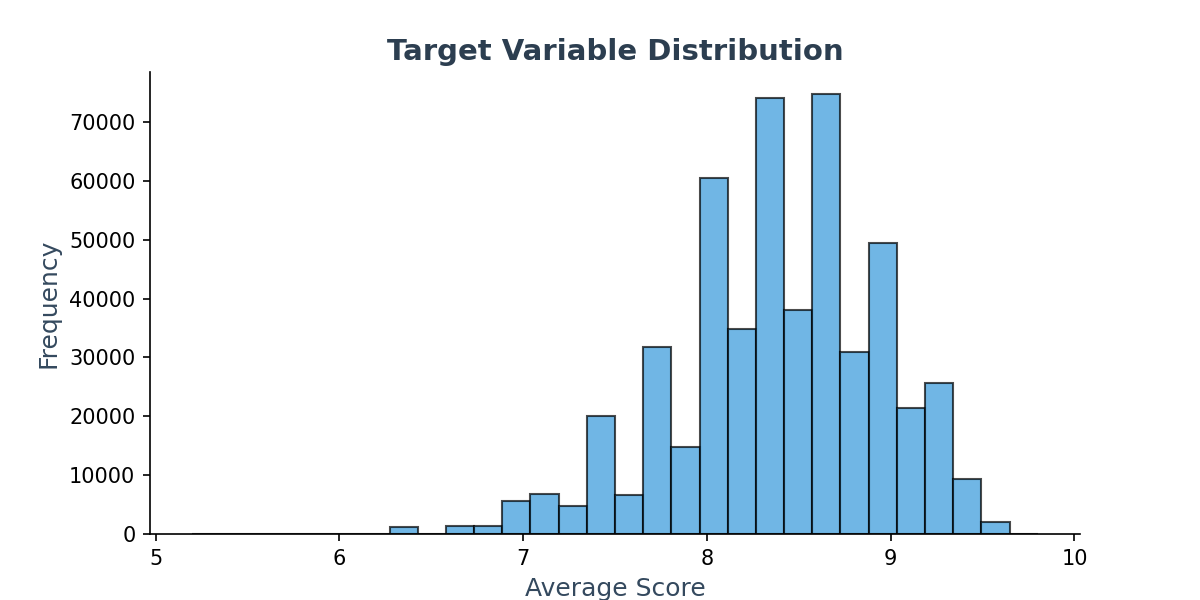

In [19]:
target_rdd = cleaned.select("Average_Score").rdd\
        .flatMap(lambda x: x)\
        .filter(lambda x: x is not None)

# Computing histogram with 30 bins
bins, counts = target_rdd.histogram(30)
bin_widths = [bins[i+1] - bins[i] for i in range(len(bins)-1)]

# Plot
plt.figure(figsize=(8, 4))
plt.bar(bins[:-1], counts, width=bin_widths, color='#3498db', edgecolor='black', alpha=0.7, align='edge')

plt.title('Target Variable Distribution', fontsize=14, fontweight='bold', color='#2c3e50')
plt.xlabel('Average Score', fontsize=12, color='#34495e')
plt.ylabel('Frequency', fontsize=12, color='#34495e')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

From the statistical summary we saw that the mean of the 'Average_Score' is close to 8.4
and from the plot we can see that our target variable is slightly skewed to the left.

This could potentially be due to the presence of an outlier around the value 6.3 - 6.4.
To be more specific about the skewness we can use .skew().

In [20]:
cleaned.select(skewness("Average_Score")).show()

+-----------------------+
|skewness(Average_Score)|
+-----------------------+
|    -0.5459206621719899|
+-----------------------+



#### Scatterplots

In [ ]:
sample_pandas = sampler.deci.toPandas()

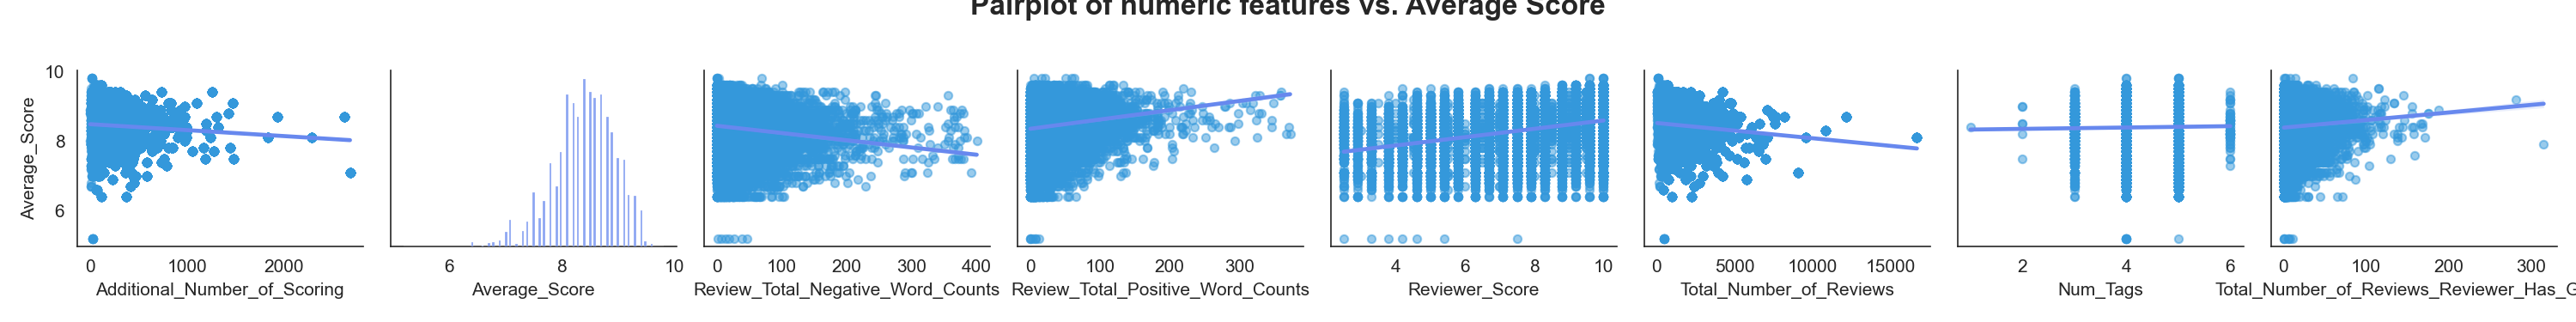

In [21]:
sns.set_style("white")
sns.set_palette("coolwarm")

# Creating the pairplot
g = sns.pairplot(
    sample_pandas,
    x_vars=numerical_features,
    y_vars="Average_Score",
    kind="reg",  # Regression line
    plot_kws={'scatter_kws': {'alpha': 0.5, 's': 20, 'color': '#3498db'}},
    height=2.5,
)

# Improve spacing
plt.suptitle("Pairplot of numeric features vs. Average Score", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Show the plot
plt.show()

We plotted some numeric features fitted using linear regression against the target variable `Average_Score`.

We notice, as expected, that individual reviewer review `Reviewer_Score`, and the total
"positive" words used in the review `Review_Total_Positive_Word_Counts` is positively correlated
with `Average_Score`. Perphaps more suprising, the more reviews a user has given `Total_Number_of_Reviews_Reviewer_Has_Given`
is also positively correlated with the venue's average score.

On the other side, we again expected that `Review_Total_Negative_Word_Counts` negatively
correlates to a venue's average score. Perphaps more suprising, the more reviews a venue has
`Total_Number_of_Reviews`, the smaller its average score

#### Visualizing correlation using a heatmap

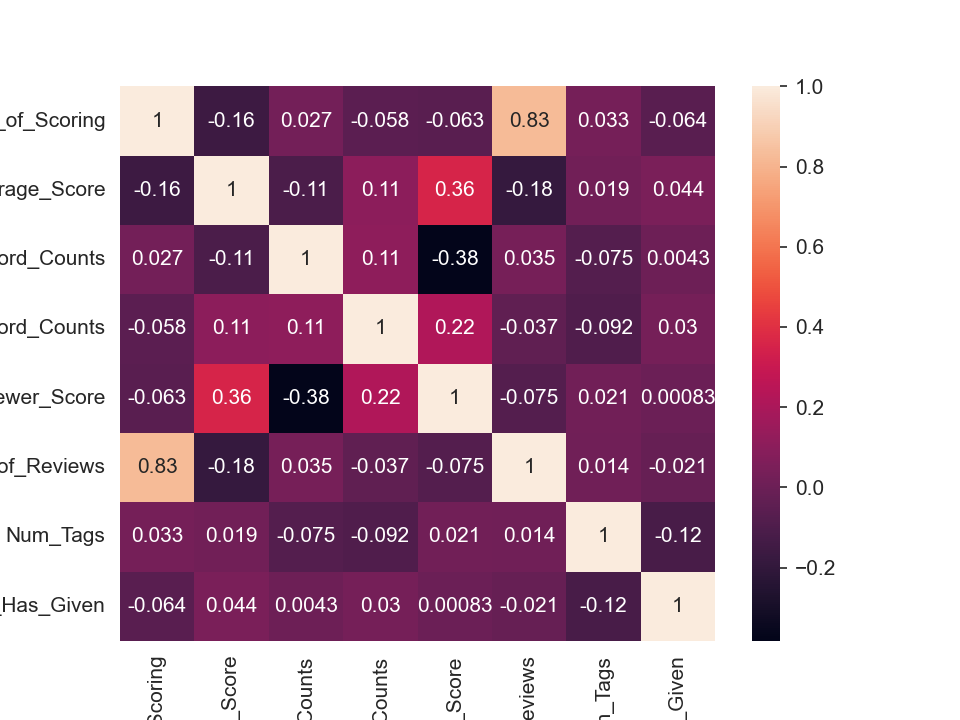

<Axes: >

In [22]:
# An alternative way to visualize linear correlation

fig, ax = plt.subplots()

sns.heatmap(sample_pandas[numerical_features].corr(method='pearson'), annot=True)

From the heatmap we can see that `Additional_Number_of_Scoring` and `Total_Number_of_Reviews`
are highly linearly correlated since the correlation coefficient is equal to 0.82 (very close to 1).

We can also see a weak linear correlation between `Additional_Number_of_Scoring`
and ΄lat΄ where the correlation coefficient is equal to 0.34.

As already studied in the previous pairplots `Average_Score` and `Reviewer_Score`
are linearly correlated even though their correlation is also pretty weak
(correlation coefficient equals to 0.37).

#### Density plots

In [23]:
print(sample_pandas.dtypes)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int32
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int32
Total_Number_of_Reviews                         int32
Positive_Review                                object
Review_Total_Positive_Word_Counts               int32
Total_Number_of_Reviews_Reviewer_Has_Given      int32
Reviewer_Score                                float64
Tags                                           object
days_since_review                               int32
lat                                           float32
lng                                           float32
Country                                        object
Country_Encoded             

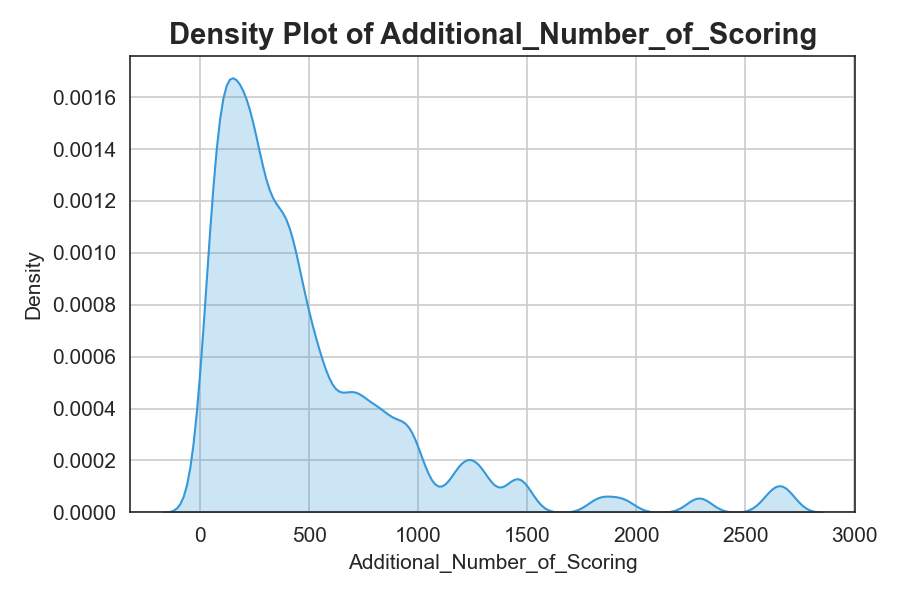

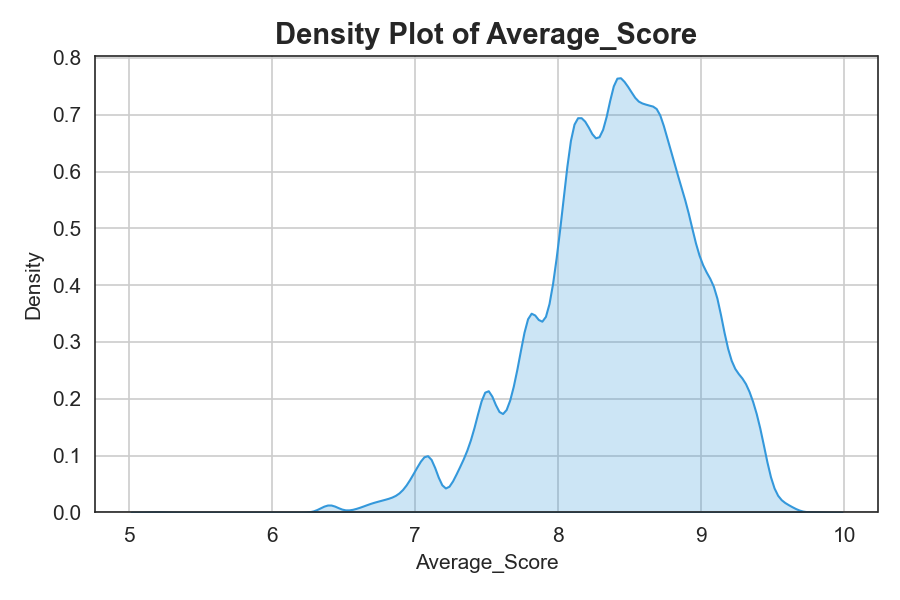

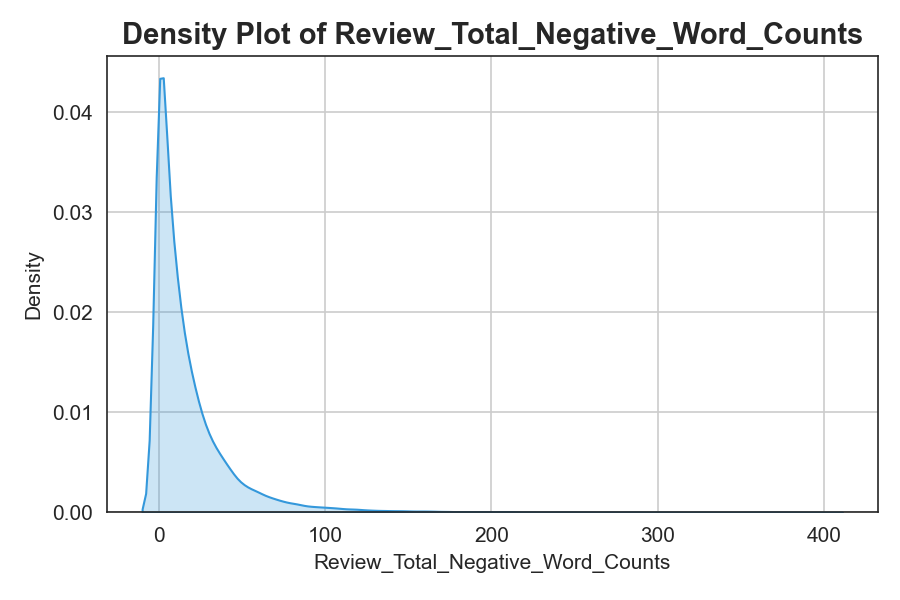

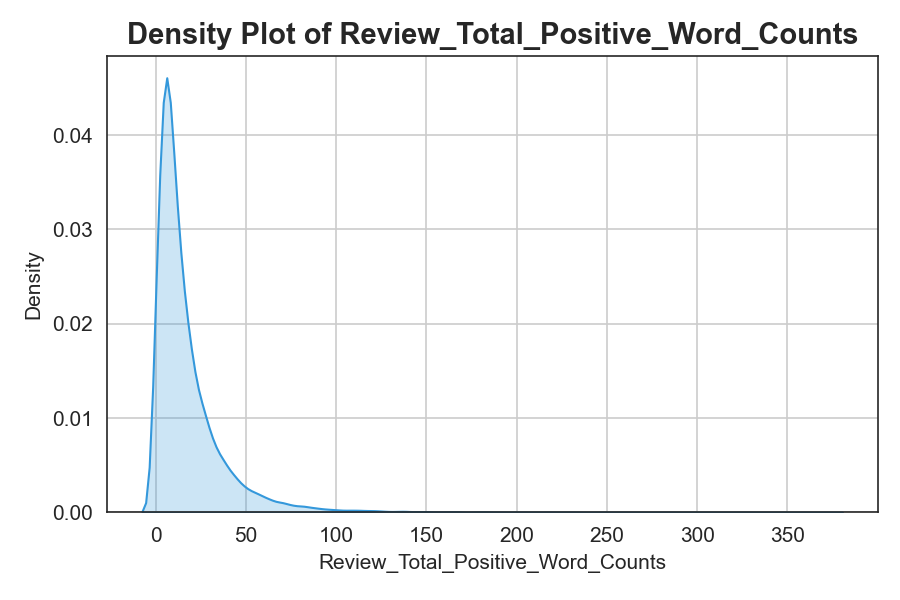

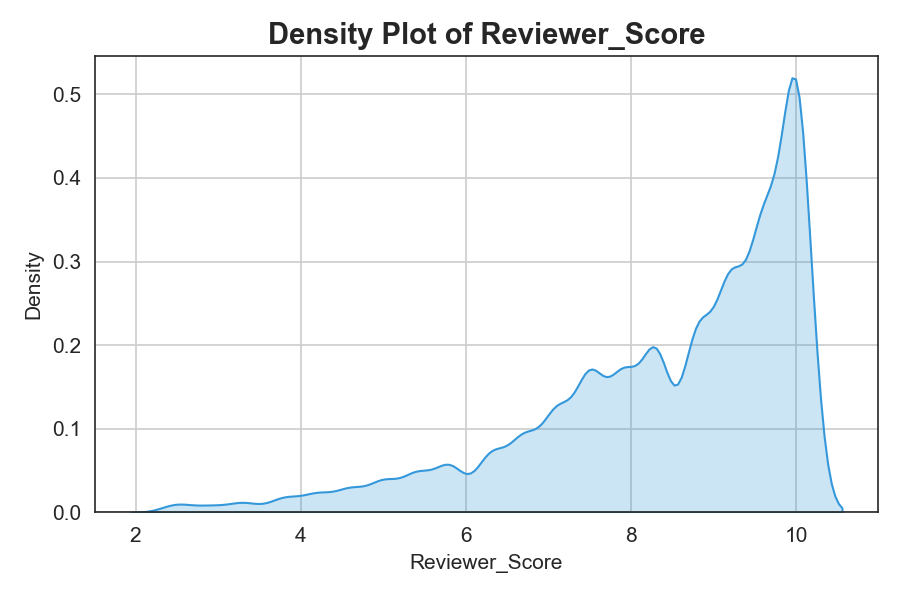

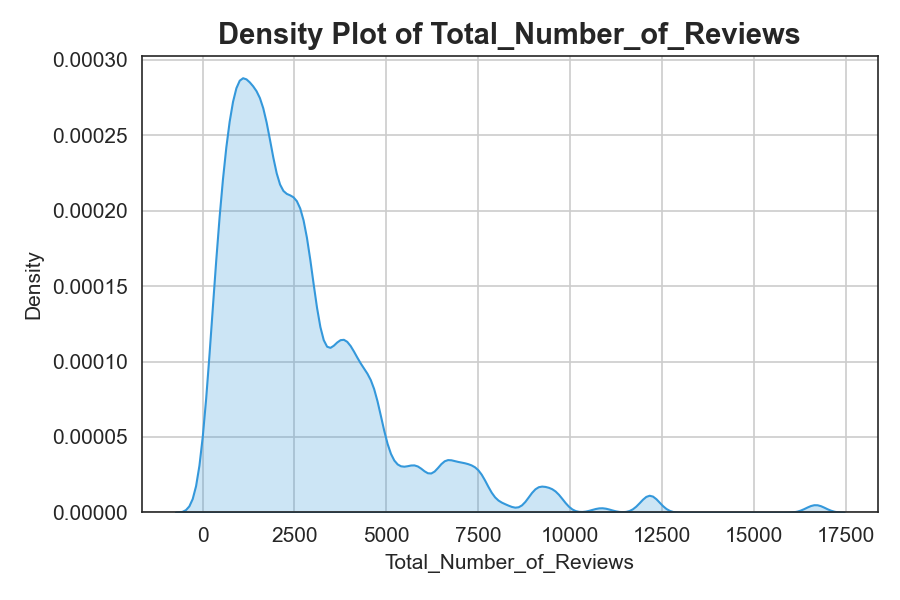

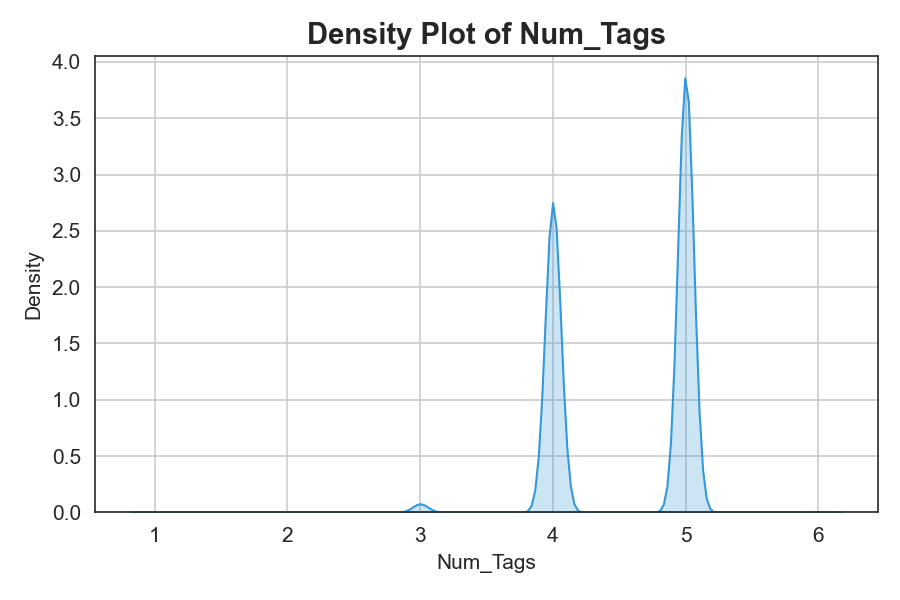

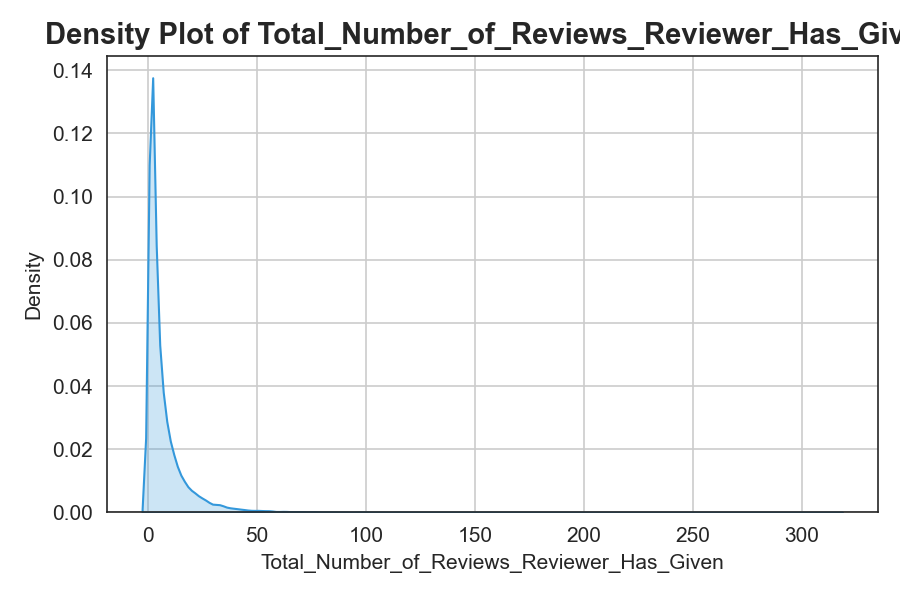

In [24]:
def print_density_plot(feature):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=sample_pandas, x=feature, fill=True, color='#3498db')
    plt.title(f'Density Plot of {feature}', fontsize=14, fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for f in numerical_features:
    print_density_plot(f)

From the density plots we can see that `Additional_Number_of_Scoring` is
skewed to the right potentialy due to the presence of extremely high values (outliers).

The same positive skew and outliers are observed in the `Total_Number_of_Reviews`.
The highest consentration of observations is observed around 12500.

`Review_Total_Positive_Word_Counts`, `Review_Total_Negative_Word_Counts` and
`Total_Number_of_Reviews_Reviewer_Has_Given` are also skewed to the right whereas
`Reviewer_Score` is negatively skewed with most od its data points consentrating around 9.8.

#### Boxplots of features with the target variable

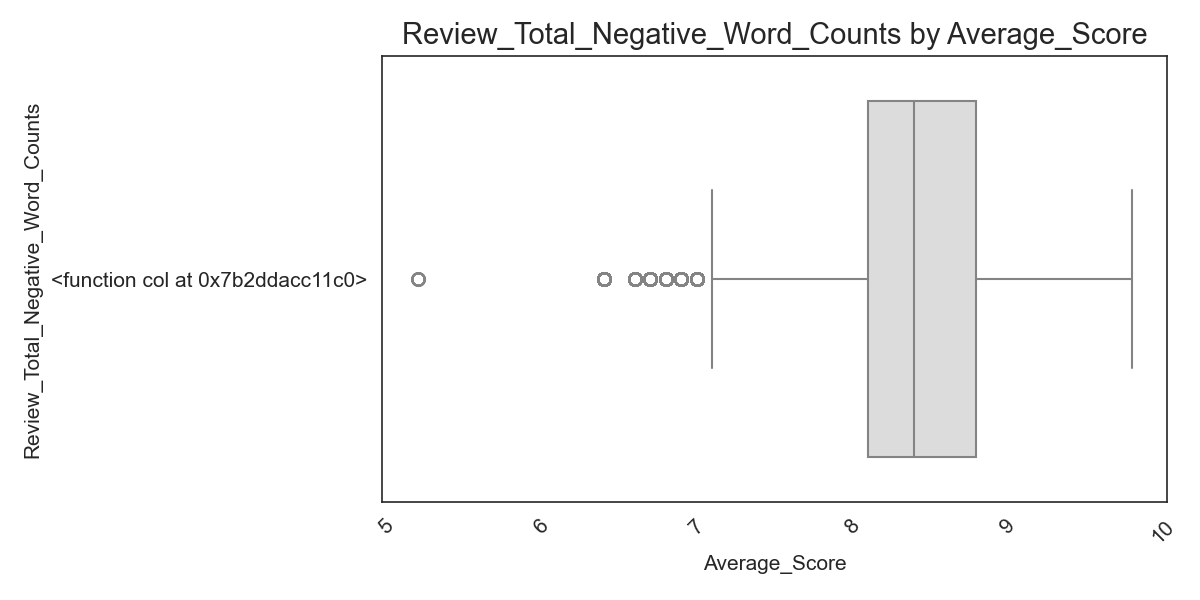

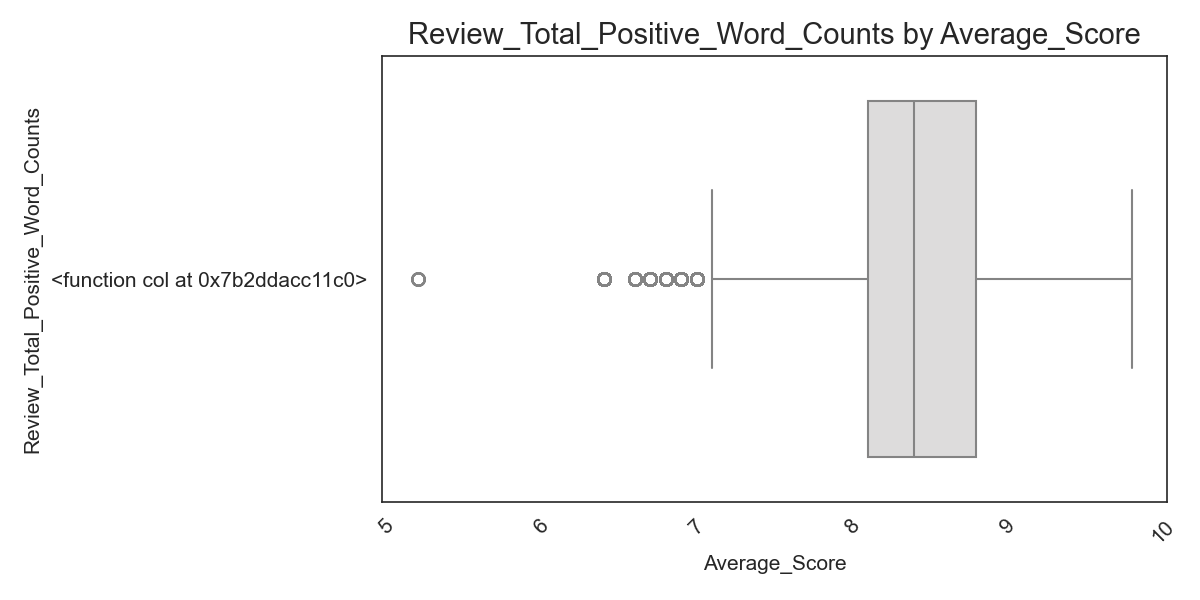

In [25]:
def print_boxplot(feature):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="Average_Score", y=col, data=sample_pandas, palette="coolwarm")
    plt.title(f'{feature} by Average_Score', fontsize=14)
    plt.xlabel("Average_Score")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


print_boxplot('Review_Total_Negative_Word_Counts')
print_boxplot('Review_Total_Positive_Word_Counts')

`Review_Total_Negative_Word_Counts` by `Average_Score`:
 - There’s a slight downward trend: as `Average_Score` increases, the number of negative words tends to decrease.
 - The median is generally lower for higher scores.
 - The distribution is very wide at each score — especially for mid-range scores (e.g., 7.0 to 8.5), meaning high variability in how many negative words are used regardless of rating.
 - Many outliers, especially in lower scores, suggest some extreme reviews with very high negativity.

`Review_Total_Positive_Word_Counts` by `Average_Score`:
 - Positive trend: as `Average_Score` increases, the number of positive words also increases.
 - The median positive word count rises steadily from low to high scores.
 - Whiskers and outliers increase with higher scores — people who are more satisfied tend to say more and more positive things.

## Natural Language Processing

In [26]:
cleaned.select("Negative_Review", "Positive_Review").show(3, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Negative_Review                                                                                                                                                               |Positive_Review                                                                                                                                                                                              |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------

In [ ]:
# We create two new columns: 'Negative_Word_Count' and 'Positive_Word_Count'
# If a review is null, we set the word count to 0
# Otherwise, we trim the review text, split it into words, and count the number of words

cleaned = cleaned.withColumn(
    "Negative_Word_Count",
    when(col("Negative_Review").isNull(), 0)
    .otherwise(size(split(trim(col("Negative_Review")), "\\s+")))
).withColumn(
    "Positive_Word_Count",
    when(col("Positive_Review").isNull(), 0)
    .otherwise(size(split(trim(col("Positive_Review")), "\\s+")))
)

In [27]:
cleaned.select(
    "Negative_Review",
    "Negative_Word_Count",
    "Review_Total_Negative_Word_Counts",
).show(5)

+--------------------+-------------------+---------------------------------+
|     Negative_Review|Negative_Word_Count|Review_Total_Negative_Word_Counts|
+--------------------+-------------------+---------------------------------+
|The bathrooms onl...|                 27|                               29|
| Bathroom very small|                  3|                                5|
|Too little wardro...|                 32|                               33|
|I found the break...|                 13|                               15|
|             Nothing|                  1|                                2|
+--------------------+-------------------+---------------------------------+
only showing top 5 rows



In [28]:
cleaned.select(
    "Positive_Review",
    "Positive_Word_Count",
    "Review_Total_Positive_Word_Counts"
).show(5)

+--------------------+-------------------+---------------------------------+
|     Positive_Review|Positive_Word_Count|Review_Total_Positive_Word_Counts|
+--------------------+-------------------+---------------------------------+
|There was a lot o...|                 38|                               40|
|Location of hotel...|                 14|                               15|
|Breakfast was ver...|                 36|                               38|
|Everything was am...|                 30|                               32|
|Great location on...|                  5|                                6|
+--------------------+-------------------+---------------------------------+
only showing top 5 rows



We created two new columns that count the actual number of words in each review.
The existing columns from the original dataset include extra blanks, so their word
counts may be inaccurate.

We will drop them from our analysis.

### Text pre-processing

Before applying any advanced analytics methods to our data, in order to execute
text analytics, we need to pre-process our text. Usually this step is consisted
by the methods we shall see below.

#### Tokenization

In [29]:
cleaned = cleaned.withColumn(
    "Negative_Review_trimmed",
    when(col("Negative_Review").isNull(), None).otherwise(trim(col("Negative_Review")))
).withColumn(
    "Positive_Review_trimmed",
    when(col("Positive_Review").isNull(), None).otherwise(trim(col("Positive_Review")))
)

cleaned = cleaned.withColumn(
    "Negative_Review_safe",
    when(col("Negative_Review_trimmed").isNull(), "").otherwise(col("Negative_Review_trimmed"))
).withColumn(
    "Positive_Review_safe",
    when(col("Positive_Review_trimmed").isNull(), "").otherwise(col("Positive_Review_trimmed"))
)

# Apply RegexTokenizer with pattern \W (non-word characters)
regex_tokenizer_neg = RegexTokenizer(inputCol="Negative_Review_safe", outputCol="Negative_Tokens_Array", pattern="\\W")
regex_tokenizer_pos = RegexTokenizer(inputCol="Positive_Review_safe", outputCol="Positive_Tokens_Array", pattern="\\W")

cleaned = regex_tokenizer_neg.transform(cleaned)
cleaned = regex_tokenizer_pos.transform(cleaned)

# Optional – Count tokens
countTokens = udf(lambda tokens: len(tokens) if tokens else None, IntegerType())

cleaned = cleaned\
    .withColumn(
        "Negative_Tokens_Count",
        when(col("Negative_Review").isNull(), None).otherwise(countTokens(col("Negative_Tokens_Array")))) \
    .withColumn("Positive_Tokens_Count",
        when(col("Positive_Review").isNull(), None).otherwise(countTokens(col("Positive_Tokens_Array"))))

cleaned\
    .select(
        "Negative_Review", "Negative_Tokens_Array", "Negative_Tokens_Count",
        "Positive_Review", "Positive_Tokens_Array", "Positive_Tokens_Count")\
    .show(5, truncate=False)

# Prepare reviews: trim, replace nulls, split into words, countwords, and display
# And for the column 'Tags' maybe we should use the regex tokenizer

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+
|Negative_Review                                                                                                        

#### Text Cleanup

In [30]:
def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, ",", " ") # Replace commas with spaces
  c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "") # Keep only alphabetic characters and numbers
  return c

# sentenceDataFrame is the dataframe we defined in our last running cell
# Apply clean_text() to multiple columns
clean_text_df = cleaned.select(
    clean_text(col("Positive_Review")).alias("Positive_Review"),
    clean_text(col("Negative_Review")).alias("Negative_Review"),
    clean_text(col("Hotel_Address")).alias("Hotel_Address"),
    clean_text(col("Hotel_Name")).alias("Hotel_Name"),
    clean_text(col("Tags")).alias("Tags"),
    clean_text(col("Reviewer_Nationality")).alias("Reviewer_Nationality")
)

clean_text_df.printSchema()
clean_text_df.show(20)

root
 |-- Positive_Review: string (nullable = true)
 |-- Negative_Review: string (nullable = true)
 |-- Hotel_Address: string (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Positive_Review|     Negative_Review|       Hotel_Address|          Hotel_Name|                Tags|Reviewer_Nationality|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|there was a lot o...|the bathrooms onl...| s gravesandestra...|         hotel arena| leisure trip    ...| united states of...|
|location of hotel...| bathroom very small|1 15 templeton pl...|    k k hotel george| leisure trip    ...|            ireland |
|breakfast was ver...|too little wardro...|1 2 serjeant s in...|apex temple court...|

We observe that some reviews contain "no" and "negative" as tokens, but they are
actually real negative reviews. For example:
> "The only negative with the room was there was no mirror outside of the bathroom."

On the other hand, some reviews that contain "no negative" actually mean that there
are no negative comments. For example:
> "I have no negative comments."

Based on this observation, we are going to clean the dataset by setting to null
to the negative reviews where "no" and "negative" appear consecutively as tokens.

In [31]:
# Define a UDF to check if the sequence "not at all" appears in the tokens
@udf(BooleanType())
def has_not_at_all_udf(tokens):
    if tokens is None or len(tokens) < 3:
        return False
    return any(tokens[i] == "not" and tokens[i+1] == "at" and tokens[i+2] == "all" for i in range(len(tokens) - 2))

# Now use it to filter
cleaned.filter(has_not_at_all_udf(col("Negative_Tokens_Array"))) \
       .select("Hotel_Name", "Negative_Review", "Negative_Tokens_Array") \
       .show(20, truncate=False)

+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Count reviews where tokens start with ["not", "at", "all"] and length is 3 or 4
count_not_at_all = cleaned.filter(
    (size(col("Negative_Tokens_Array")).isin(3, 4)) &  # Exactly 3 or 4 5 tokens
    (col("Negative_Tokens_Array")[0] == "not") &
    (col("Negative_Tokens_Array")[1] == "at") &
    (col("Negative_Tokens_Array")[2] == "all")
).count()

print(f"Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: {count_not_at_all}")

Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: 12


In [ ]:
# Replace reviews that start with "not at all" and have exactly 3 or 4 tokens
cleaned = cleaned.withColumn(
    "Negative_Review",
    when(
        (size(col("Negative_Tokens_Array")).isin(3, 4)) &
        (col("Negative_Tokens_Array")[0] == "not") &
        (col("Negative_Tokens_Array")[1] == "at") &
        (col("Negative_Tokens_Array")[2] == "all"),
        lit(None)
    ).otherwise(col("Negative_Review"))
).withColumn(
    "Negative_Tokens_Array",
    when(
        (size(col("Negative_Tokens_Array")).isin(3, 4)) &
        (col("Negative_Tokens_Array")[0] == "not") &
        (col("Negative_Tokens_Array")[1] == "at") &
        (col("Negative_Tokens_Array")[2] == "all"),
        array()  # Set tokens to empty array []
    ).otherwise(col("Negative_Tokens_Array"))
).withColumn(
    "Negative_Tokens_Count",
    when(
        (size(col("Negative_Tokens_Array")).isin(3, 4)) &
        (col("Negative_Tokens_Array")[0] == "not") &
        (col("Negative_Tokens_Array")[1] == "at") &
        (col("Negative_Tokens_Array")[2] == "all"),
        lit(0)  # Set token count to 0
    ).otherwise(col("Negative_Tokens_Count"))
)

In [33]:
# Rerunning the code to verify that the reviews mentioned above have now been replaced
count_not_at_all = cleaned.filter(
    (size(col("Negative_Tokens_Array")).isin(3, 4)) &  # Exactly 3 or 4 5 tokens
    (col("Negative_Tokens_Array")[0] == "not") &
    (col("Negative_Tokens_Array")[1] == "at") &
    (col("Negative_Tokens_Array")[2] == "all")
).count()

print(f"Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: {count_not_at_all}")

Number of reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: 0


Here, we essentially want to consider only reviews where the negative review starts
with "not at all". However, we restrict the number of tokens to exactly 3 or 4,
in order to include only short reviews that consist solely of these tokens.

For example, reviews like "Club staff was not at all friendly at all in fact"
should not be counted, because they have more than 4 tokens and "not at all" is
not the entire review — and these are actually negative reviews.

In [34]:
# Find and count reviews where:
# - Negative_Tokens_Array contains "nothing"
# - and the number of tokens is exactly 1 or 2
count_nothing_restricted = cleaned.filter(
    array_contains(col("Negative_Tokens_Array"), "nothing") &
    (size(col("Negative_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted}")

Number of reviews containing the token 'nothing' with 1 or 2 tokens: 22626


These reviews do not actually contain anything negative and should be considered as null.
Their tokens should also be set to an empty array (zero tokens), so that the models we
build later do not make decisions based on them.

In [ ]:
# Replace reviews containing only "nothing" (with 1 or 2 tokens) with null reviews and empty token arrays
cleaned = cleaned.withColumn(
    "Negative_Review",
    when(
        array_contains(col("Negative_Tokens_Array"), "nothing") & size(col("Negative_Tokens_Array")).isin(1, 2),
        lit(None)  # Set review to null
    ).otherwise(col("Negative_Review"))
).withColumn(
    "Negative_Tokens_Array",
    when(
        array_contains(col("Negative_Tokens_Array"), "nothing") & size(col("Negative_Tokens_Array")).isin(1, 2),
        array()  # Set tokens to empty array
    ).otherwise(col("Negative_Tokens_Array"))
).withColumn(
    "Negative_Tokens_Count",
    when(
        array_contains(col("Negative_Tokens_Array"), "nothing") & size(col("Negative_Tokens_Array")).isin(1, 2),
        lit(0)  # Set token count to 0
    ).otherwise(col("Negative_Tokens_Count"))
)

In [35]:
# Rerunning the code to verify that the reviews mentioned above have now been replaced

count_nothing_restricted = cleaned.filter(
    array_contains(col("Negative_Tokens_Array"), "nothing") &
    (size(col("Negative_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted}")

Number of reviews containing the token 'nothing' with 1 or 2 tokens: 0


In [36]:
# Define UDF to check if "no" is followed by "negative"
@udf(BooleanType())
def has_no_negative_pair_udf(tokens):
    if tokens is None or len(tokens) < 2:
        return False
    return any(tokens[i] == "no" and tokens[i+1] == "negative" for i in range(len(tokens) - 1))

# Apply the filter and show rows
cleaned.filter(has_no_negative_pair_udf(col("Negative_Tokens_Array"))) \
    .select("Negative_Review", "Negative_Tokens_Array") \
    .show(20, truncate=False)

+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+
|Negative_Review                                                                 |Negative_Tokens_Array                                                                            |
+--------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+
|I had no negative experiences                                                   |[i, had, no, negative, experiences]                                                              |
|We had no negative experiences                                                  |[we, had, no, negative, experiences]                                                             |
|No negative comments                                                            |[no, negative

In [37]:
no_negative_count = cleaned.filter(has_no_negative_pair_udf(col("Negative_Tokens_Array"))).count()

print(f"Number of reviews with 'no' followed by 'negative': {no_negative_count}")

Number of reviews with 'no' followed by 'negative': 140


Some hotels have non-negative reviews recorded as negative reviews, as their texts
contain the consecutive words "no" and "negative." These reviews were not treated as
nulls, leading to incorrect labeling and introducing bias into the dataset.

In [ ]:
# Set Negative_Review to null, Negative_Tokens_Array to empty array, and Negative_Tokens_Count to 0 if "no negative" appears
cleaned = cleaned.withColumn(
    "Negative_Review",
    when(
        has_no_negative_pair_udf(col("Negative_Tokens_Array")),
        None  # Set review to null
    ).otherwise(col("Negative_Review"))
).withColumn(
    "Negative_Tokens_Array",
    when(
        has_no_negative_pair_udf(col("Negative_Tokens_Array")),
        array()  # Set tokens to empty array []
    ).otherwise(col("Negative_Tokens_Array"))
).withColumn(
    "Negative_Tokens_Count",
    when(
        has_no_negative_pair_udf(col("Negative_Tokens_Array")),
        lit(0)  # Set token count to 0
    ).otherwise(col("Negative_Tokens_Count"))
)

In [38]:
# Re-running the code to check if the records we observed have been replaced

no_negative_count = cleaned.filter(has_no_negative_pair_udf(col("Negative_Tokens_Array"))).count()

print(f"Number of reviews with 'no' followed by 'negative': {no_negative_count}")

Number of reviews with 'no' followed by 'negative': 0


Now we are going to clean the positive reviews ( same process as above)

In [39]:
# Define a UDF to check if "no" is immediately followed by "positive" in Positive_Tokens_Array
@udf(BooleanType())
def has_no_positive_pair_udf(tokens):
    if tokens is None or len(tokens) < 2:
        return False
    return any(tokens[i] == "no" and tokens[i+1] == "positive" for i in range(len(tokens) - 1))

# Apply the filter
cleaned.filter(
    has_no_positive_pair_udf(col("Positive_Tokens_Array"))
).select("Positive_Review", "Positive_Tokens_Array") \
 .show(20, truncate=False)

# We filter the dataset to find reviews where "no" is immediately followed by "positive" in the Positive_Tokens_Array
# Then we select and display the original positive review text and its tokens for inspection

+----------------------+----------------------------+
|Positive_Review       |Positive_Tokens_Array       |
+----------------------+----------------------------+
|No positive side of it|[no, positive, side, of, it]|
|No positive commment  |[no, positive, commment]    |
+----------------------+----------------------------+



In [40]:
# Count positive reviews where tokens start with ["not", "at", "all"] and length is 3 or 4
count_not_at_all_positive = cleaned.filter(
    (size(col("Positive_Tokens_Array")).isin(3, 4)) &  # Exactly 3 or 4 tokens
    (col("Positive_Tokens_Array")[0] == "not") &
    (col("Positive_Tokens_Array")[1] == "at") &
    (col("Positive_Tokens_Array")[2] == "all")
).count()

print(f"Number of positive reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: {count_not_at_all_positive}")

# We count the number of positive reviews that start with "not at all" and have exactly 3 or 4 tokens

Number of positive reviews starting with tokens ['not', 'at', 'all'] and size 3 or 4: 1


In [41]:
# Find and count positive reviews where:
# - Positive_Tokens_Array contains "nothing"
# - and the number of tokens is exactly 1 or 2
count_nothing_restricted_positive = cleaned.filter(
    array_contains(col("Positive_Tokens_Array"), "nothing") &
    (size(col("Positive_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of positive reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted_positive}")

# We count positive reviews that only say "nothing" and have exactly 1 or 2 tokens

Number of positive reviews containing the token 'nothing' with 1 or 2 tokens: 1952


The number of positive reviews that do not correspond to actual positive reviews
is smaller compared to the negative reviews we saw earlier.

Therefore, we will only replace with missing values the observations that have no comment,
and handle only those specific cases.(above code)

In [ ]:
# Replace positive reviews where:
# - Positive_Tokens_Array contains "nothing"
# - and the number of tokens is exactly 1 or 2
cleaned = cleaned.withColumn(
    "Positive_Review",
    when(
        array_contains(col("Positive_Tokens_Array"), "nothing") & size(col("Positive_Tokens_Array")).isin(1, 2),
        lit(None)
    ).otherwise(col("Positive_Review"))
).withColumn(
    "Positive_Tokens_Array",
    when(
        array_contains(col("Positive_Tokens_Array"), "nothing") & size(col("Positive_Tokens_Array")).isin(1, 2),
        array()
    ).otherwise(col("Positive_Tokens_Array"))
).withColumn(
    "Positive_Tokens_Count",
    when(
        array_contains(col("Positive_Tokens_Array"), "nothing") & size(col("Positive_Tokens_Array")).isin(1, 2),
        lit(0)
    ).otherwise(col("Positive_Tokens_Count"))
)

# We replace positive reviews containing only "nothing" with null reviews and empty token arrays

In [42]:
#Rerruning the code
count_nothing_restricted_positive = cleaned.filter(
    array_contains(col("Positive_Tokens_Array"), "nothing") &
    (size(col("Positive_Tokens_Array")).isin(1, 2))
).count()

print(f"Number of positive reviews containing the token 'nothing' with 1 or 2 tokens: {count_nothing_restricted_positive}")

# We count positive reviews that only say "nothing" and have exactly 1 or 2 tokens

Number of positive reviews containing the token 'nothing' with 1 or 2 tokens: 0


It is important to note that the previous step of cleaning some reviews,
which were considered neither negative nor positive and contained the word "no,"
must take place at this part of the code.

This is because, after removing the stop words, "no" would have been removed.

### Removing Stopwords

Stopwords are words such as "and" and "the" that typically do not add value to the
semantic meaning of a sentence. We typically want to remove these as a means to
reduce the noise in our text datasets.

In [43]:
# Step 4: Remove Stopwords
stopwords_remover_neg = StopWordsRemover(inputCol="Negative_Tokens_Array", outputCol="Negative_Filtered_Tokens")
stopwords_remover_pos = StopWordsRemover(inputCol="Positive_Tokens_Array", outputCol="Positive_Filtered_Tokens")

cleaned = stopwords_remover_neg.transform(cleaned)
cleaned = stopwords_remover_pos.transform(cleaned)

# Step 5: Count tokens (after stopword removal)
countTokens = udf(lambda tokens: len(tokens) if tokens else None, IntegerType())

cleaned = cleaned.withColumn(
    "Negative_Tokens_Count", when(col("Negative_Review").isNull(), None).otherwise(countTokens(col("Negative_Filtered_Tokens")))
).withColumn(
    "Positive_Tokens_Count", when(col("Positive_Review").isNull(), None).otherwise(countTokens(col("Positive_Filtered_Tokens")))
)

# Step 6: Show results
cleaned.select(
    "Negative_Review", "Negative_Filtered_Tokens", "Negative_Tokens_Count",
    "Positive_Review", "Positive_Filtered_Tokens", "Positive_Tokens_Count"
).show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+
|Negative_Review                                                                                                                                                               |Negative_Filtered_Tokens                                                                                                 |Negativ

### 1.7 Lemmatizing

In [44]:
# TODO: Say why we are using nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

True

In [ ]:
lemmatizer = WordNetLemmatizer()

# Python function for lemmatizing
@udf(ArrayType(StringType()))
def lemmer_udf(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens] if tokens else []

In [ ]:
# Apply lemmatization to the filtered token columns:

cleaned = cleaned.withColumn("Negative_Lemmatized", lemmer_udf(col("Negative_Filtered_Tokens")))
cleaned = cleaned.withColumn("Positive_Lemmatized", lemmer_udf(col("Positive_Filtered_Tokens")))

In [ ]:
# Re-count after lemmatization:
cleaned = cleaned.withColumn("Negative_Lemma_Count", countTokens(col("Negative_Lemmatized")))
cleaned = cleaned.withColumn("Positive_Lemma_Count", countTokens(col("Positive_Lemmatized")))

In [45]:
# final columns
cleaned.select(
    "Negative_Review", "Negative_Filtered_Tokens", "Negative_Lemmatized", "Negative_Lemma_Count",
    "Positive_Review", "Positive_Filtered_Tokens", "Positive_Lemmatized", "Positive_Lemma_Count"
).show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|Negative_Review                             

In [46]:
# Count how many rows have nulls in Positive_Tokens_Count
positive_nulls = cleaned.filter(col("Positive_Tokens_Count").isNull()).count()

# Count how many rows have nulls in Negative_Tokens_Count
negative_nulls = cleaned.filter(col("Negative_Tokens_Count").isNull()).count()

print(f"Number of nulls in Positive_Tokens_Count: {positive_nulls}")
print(f"Number of nulls in Negative_Tokens_Count: {negative_nulls}")

Number of nulls in Positive_Tokens_Count: 38561
Number of nulls in Negative_Tokens_Count: 153172


In [47]:
# Count nulls in Negative_Tokens_Count
nulls_negative_tokens = cleaned.filter(col("Negative_Lemma_Count").isNull()).count()

# Count nulls in Positive_Tokens_Count
nulls_positive_tokens = cleaned.filter(col("Positive_Lemma_Count").isNull()).count()

print(f"Number of nulls in Negative_Tokens_Count: {nulls_negative_tokens}")
print(f"Number of nulls in Positive_Tokens_Count: {nulls_positive_tokens}")

Number of nulls in Negative_Tokens_Count: 153172
Number of nulls in Positive_Tokens_Count: 38561


In [ ]:
# End of NLP processing

# CHECKPOINT 2

if True:
    persist('2-NLP')
else:
    restore('2-NLP')

## Graph Analysis

For the graph analysis we needed to use a unique reviewer id in order to be able
to match reviewerx with hotels. Since the dataset didn't provide as with one we decided
to create a reviewer id using the features we already had. The ids were create using the following features:

1. **`Reviewer_Nationality`:** which gives geographic context of the reviewer.
1. **`Tags`:** which reflects the type of traveler (e.g., 'Solo', 'Couple').
1. **`Total_Number_of_Reviews_Reviewer_Has_Given`:** adds some numeric uniqueness.

Given the features we had available this was the best we could do with creating a unique id for each reviewer. In reality those ids are not truly unique due to collisions are likely to happen in large datasets.

In [ ]:
df = cleaned.withColumn(
    "reviewer_id",
    concat_ws("_",
        col("Reviewer_Nationality"),
        col("Tags"),
        col("Total_Number_of_Reviews_Reviewer_Has_Given").cast("string")
    )
)

# Build edge list: reviewer -->hotel
edge_list = df.select(
    df["reviewer_id"].alias("src"),
    df["Hotel_Name"].alias("dst"),
    df["Reviewer_Score"].alias("weight")
)

# Graph visualization

def plot_directed_graph(edge_list, weighted=True):
    plt.figure(figsize=(12, 9))
    gPlot = nx.DiGraph()
    edge_labels = {}

    edge_char = "weight" if weighted else "relationship"

    # Add edges (limit for visualization)
    for row in edge_list.select("src", "dst", edge_char).take(1000):
        gPlot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row[edge_char]

    # Layout and drawing
    pos = nx.spring_layout(gPlot, k=0.15, iterations=20)
    nx.draw(gPlot, pos, with_labels=False, node_size=50, edge_color='gray')
    nx.draw_networkx_edge_labels(gPlot, pos, edge_labels=edge_labels, font_color="green", font_size=8)

    plt.title("Reviewer–Hotel Bipartite Graph (Profile-Based Reviewer ID)")
    plt.show()

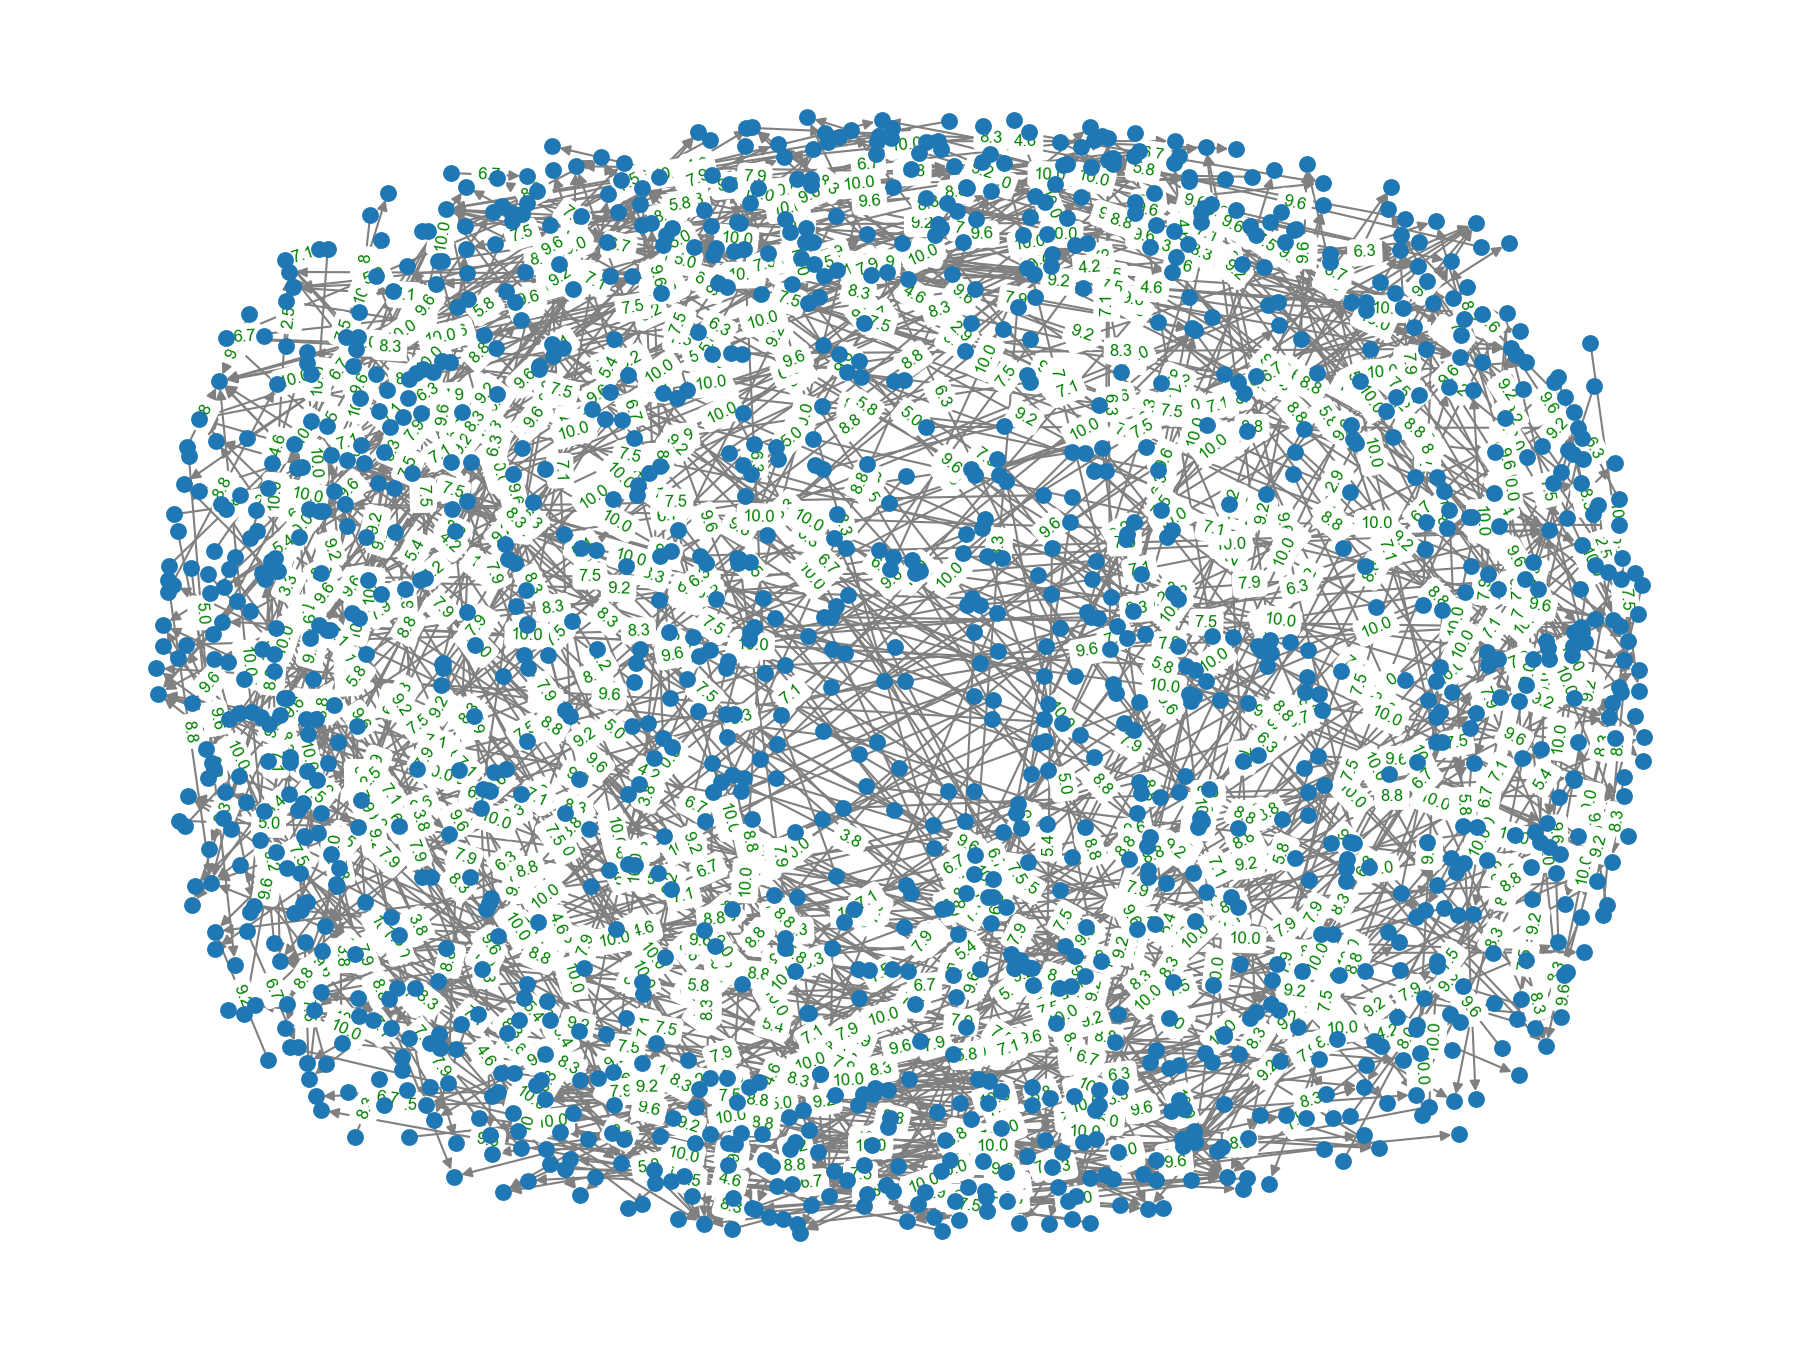

In [48]:
plot_directed_graph(edge_list, weighted=True)

After implementing graph analysis it was used for a recommendetion system that
would recommend a hotel to a cutsomer based of the reviews they left using their
identification fingerprint.

In [ ]:
gPlot = nx.DiGraph()

for row in edge_list.select("src", "dst", "weight").collect():
    gPlot.add_edge(row["src"], row["dst"], weight=row["weight"])

The following code basically ranks a list of popular hotels by how many people reviewed them.

In [49]:
hotel_degrees = [(n, gPlot.degree(n)) for n in gPlot.nodes if "Hotel" in n]
top_hotels = sorted(hotel_degrees, key=lambda x: x[1], reverse=True)[:10]
top_reviewers = sorted(
    [(n, gPlot.degree(n)) for n in gPlot.nodes if "Hotel" not in n],
    key=lambda x: x[1], reverse=True
)[:10]

print("Top-reviewed hotels:", top_hotels)

Top-reviewed hotels: [('Strand Palace Hotel', 2525), ('Copthorne Tara Hotel London Kensington', 2231), ('Britannia International Hotel Canary Wharf', 2112), ('Hotel Da Vinci', 1783), ('Millennium Gloucester Hotel London', 1650), ('St James Court A Taj Hotel London', 1502), ('DoubleTree by Hilton Hotel London Tower of London', 1448), ('The Cumberland A Guoman Hotel', 1440), ('Best Western Premier Hotel Couture', 1353), ('Hotel Esther a', 1322)]


In [50]:
# Filtering dataset to get average scores for the top 10 hotels
avg_scores = df.filter(col('Hotel_Name').isin(list(map(lambda h: h[0], top_hotels))))\
    .select('Hotel_Name', 'Average_Score')\
    .distinct()

avg_scores.show()

+--------------------+-------------+
|          Hotel_Name|Average_Score|
+--------------------+-------------+
|Copthorne Tara Ho...|          8.1|
|Millennium Glouce...|          7.8|
|DoubleTree by Hil...|          8.7|
|      Hotel Esther a|          9.1|
| Strand Palace Hotel|          8.1|
|The Cumberland A ...|          7.5|
|      Hotel Da Vinci|          8.1|
|Best Western Prem...|          8.7|
|St James Court A ...|          8.7|
|Britannia Interna...|          7.1|
+--------------------+-------------+



## Recommendation systems - Collaborative filtering

In [ ]:
# We encode 'reviewer_id' and 'Hotel_Name' into numeric form
reviewer_indexer = StringIndexer(inputCol="reviewer_id", outputCol="reviewer_id_index").setHandleInvalid("keep")
hotel_indexer = StringIndexer(inputCol="Hotel_Name", outputCol="hotel_id_index").setHandleInvalid("keep")

# Applying transformations
df = reviewer_indexer.fit(df).transform(df)
df = hotel_indexer.fit(df).transform(df)

# We split the data into training and test sets
training_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print("Training rows:", training_data.count())
print("Test rows:", test_data.count())

# Building the ALS model
als = ALS(
    maxIter=10,
    regParam=0.01,
    rank=10,  # controls latent factor dimensionality
    userCol="reviewer_id_index",
    itemCol="hotel_id_index",
    ratingCol="Reviewer_Score",
    coldStartStrategy="drop"
)

# Training the model
model = als.fit(training_data)

# Generating the top 10 hotel recommendations for each reviewer
user_recs = model.recommendForAllUsers(10)

# We flatten recommendation arrays
user_recs = user_recs.selectExpr("reviewer_id_index", "explode(recommendations) as recommendation")
user_recs = user_recs.selectExpr(
    "reviewer_id_index",
    "recommendation.hotel_id_index as hotel_id_index",
    "recommendation.rating as rating"
)

user_recs.show(truncate=False)

### RMSE Evaluation

In [ ]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Reviewer_Score", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

## Machine Learning

Here we are going to create the different datasets that will be used throughout
the machine learning process. First, we will create a smaller sample of the full
dataset to allow faster execution of some machine learning models during development
and testing.

We will also generate an aggregated dataset that summarizes the review results
for each hotel, providing useful features such as average sentiment score or total
number of reviews.

After preparing these datasets, we will proceed to build and evaluate different
machine learning models for sentiment classification.

It is important to note that during the machine learning modeling process,
cross-validation was not applied. We are aware that using cross-validation is the
proper and more reliable approach for evaluating models, especially when combined
with appropriate data splitting. Although a train-test split was used, running
cross-validation proved to be quite time-consuming due to the size of the dataset
and the complexity of some models.

**Therefore, cross-validation may be applied in future steps, particularly for
models with longer training times or in order to further optimize performance.**

Fist we aggregate the numerical columns over each hotel in the dataset to calculate
the averages.

To overcome the computational performance issue, we will work from a sample,
and performing selective sampling, i.e. intelligently choosing how to sample.

Our approach was to keep only hotels with the most reviews. We know that selecting
hotels based on the number of reviews is a convenient approach and not always
realistic in practice, but it helps us develop and test our models more efficiently
during the early stages.

In [ ]:
# Group by hotel and count reviews
hotel_counts = cleaned.groupBy("Hotel_Name").agg(count("*").alias("review_count"))

# Order by review count descending
ordered_hotels = hotel_counts.orderBy("review_count", ascending=False)

# Collect hotel list to Python
hotel_list = ordered_hotels.collect()

# Build list of hotels until reaching ~50,000 reviews
selected_hotels = []
running_total = 0

for row in hotel_list:
    hotel_name = row["Hotel_Name"]
    count_reviews = row["review_count"]
    if running_total + count_reviews <= 50000:
        selected_hotels.append(hotel_name)
        running_total += count_reviews
    else:
        break

# Filter Spark DataFrame for these top hotels
clean_reduced_hotels_most_reviews = cleaned.filter(col("Hotel_Name").isin(selected_hotels))

In [51]:
print(f'Using a sample of {clean_reduced_hotels_most_reviews.count()} / {cleaned.count()}')

Using a sample of 48858 / 515212


Now we aggregate the numerical columns over each hotel in the dataset to calculate
the averages.

In [52]:
# Defining columns on which we will compute averages
columns_to_average = [
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Total_Number_of_Reviews',
    'Total_Number_of_Reviews_Reviewer_Has_Given',
    'days_since_review',
    'Num_Tags',
    'Positive_Lemma_Count',
    'Negative_Lemma_Count'
]

# Building aggregation expressions
agg_exprs = [avg(col(feat)).alias(f"avg_{feat}") for feat in columns_to_average]

# Grouping by hotel and compute averages
hotel_avg_stats = cleaned.groupBy("Hotel_Name").agg(*agg_exprs)

# Computing review counts per hotel
hotel_counts = cleaned.groupBy("Hotel_Name").agg(count("*").alias("review_count"))

# Now we are joining the two DataFrames on Hotel_Name
hotel_avg_stats_with_counts = hotel_avg_stats.join(hotel_counts, on="Hotel_Name")

# Filtering for hotels with more than 30 reviews
hotel_avg_stats_filtered = hotel_avg_stats_with_counts.filter("review_count > 30")

hotel_avg_stats_filtered.show(truncate=False)

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
Cell In[66], line 17
     14 agg_exprs = [avg(col(column_name)).alias(f"avg_{column_name}") for column_name in columns_to_average]
     16 # Grouping by hotel and compute averages
---> 17 hotel_avg_stats = cleaned.groupBy("Hotel_Name").agg(*agg_exprs)
     19 # Computing review counts per hotel
     20 hotel_counts = cleaned.groupBy("Hotel_Name").agg(count("*").alias("review_count"))

File ~/Documents/ucy/data-science-master/dsc-511-big-data-analytics/dsc511-group-project/venv/lib/python3.12/site-packages/pyspark/sql/group.py:186, in GroupedData.agg(self, *exprs)
    184     assert all(isinstance(c, Column) for c in exprs), "all exprs should be Column"
    185     exprs = cast(Tuple[Column, ...], exprs)
--> 186     jdf = self._jgd.agg(exprs[0]._jc, _to_seq(self.session._sc, [c._jc for c in exprs[1:]]))
    187 return DataFrame(jdf, self

In [53]:
print(f'Using a sample of {hotel_avg_stats_filtered.count()} / {cleaned.count()}')

Using a sample of 515212 / 9045


In [ ]:
hotel_avg_stats_filtered.count()

Here we build a regression model to predict the average hotel review score based
on aggregated features derived from user reviews.

We begin by computing per-hotel averages of various numerical attributes
(such as number of reviews, geographic coordinates, and word counts). We then filter
out hotels with fewer than 30 reviews and those missing geographic data.
Using these cleaned and aggregated values, we assemble a feature vector for each
hotel and train a linear regression model to estimate the average review score.

The dataset is split into training and testing sets, and we evaluate the model's
performance using RMSE and $R2$ metrics to assess prediction accuracy and fit quality.

The below code has to do with model

In [ ]:
agg_exprs = [avg(col).alias(f"avg_{col}") for col in columns_to_average]
hotel_avg_stats = cleaned.groupBy("Hotel_Name").agg(*agg_exprs)

# Adding the review count and filtering hotels with > 30 reviews
hotel_counts = cleaned.groupBy("Hotel_Name").agg(count("*").alias("review_count"))
hotel_avg_stats_with_counts = hotel_avg_stats.join(hotel_counts, on="Hotel_Name")
hotel_avg_stats_filtered = hotel_avg_stats_with_counts.filter("review_count > 30")

# Assemble features
feature_cols = [
    'avg_Additional_Number_of_Scoring',
    'avg_Total_Number_of_Reviews',
    'avg_Total_Number_of_Reviews_Reviewer_Has_Given',
    'avg_days_since_review',
    'avg_Num_Tags',
    'avg_Positive_Lemma_Count',
    'avg_Negative_Lemma_Count',
    'Country_Encoded',
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(hotel_avg_stats_filtered)

# Preparing the final dataset with label
final_data = assembled_data.select("features", col("avg_Average_Score").alias("label"))

# Splitting the dataset into train and test
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Training linear regression model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Making predictions on test set
predictions = lr_model.transform(test_data)

# Evaluating the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE on test set: {rmse}")
print(f"R² on test set: {r2}")

We can see that the linear regression model achieved an RMSE of approximately 0.38,
indicating that, on average, the predicted hotel scores deviate from the actual score
s by less than half a point. Additionally, the model achieved an R² of 0.49,
meaning it explains about 49% of the variance in average hotel scores.

This suggests that while the model captures some meaningful patterns in the data,
there is still substantial variability in hotel ratings that remains unexplained
by the current features. These results indicate a moderate predictive performance,
and could potentially be improved by using more complex models (like Random Forest
or Gradient Boosting) or by incorporating richer features such as text sentiment
from reviews or location-based attributes.

In [ ]:
# First we define the models we want to try out, all using the same features and label
models = {
    "Linear Regression": LinearRegression(featuresCol="features", labelCol="label"),
    "Random Forest": RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100),
    "Gradient Boosted Trees": GBTRegressor(featuresCol="features", labelCol="label", maxIter=100)
}

# Now we set up the evaluators — one for RMSE and one for R²
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

results = []

# Here we loop through the models, fit them, predict, and evaluate
for name, model in models.items():
    fitted = model.fit(train_data)               # we train the model
    preds = fitted.transform(test_data)          # then make predictions on the test set

    rmse = evaluator_rmse.evaluate(preds)        # calculate RMSE
    r2 = evaluator_r2.evaluate(preds)            # calculate R²

    results.append((name, rmse, r2))             # save the results

# Finally we print out the results in a clean format
for name, rmse, r2 in results:
    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

Linear Regression performs best among the three models — it has the lowest RMSE (0.3766)
and the highest R² (0.4892). This suggests that, despite being a simpler model,
it captures the underlying patterns in your aggregated dataset more effectively
than the tree-based models.

Random Forest and GBT perform slightly worse, with higher RMSE and lower R².
This may be surprising since these models typically outperform linear models on
complex data — but in your case, the features are already averaged per hotel,
which may remove much of the non-linear variation and noise that tree models are
good at exploiting.

This implies your data relationships are relatively linear, or at least
well-approximated by a linear function at this aggregation level.

We saved the predictions only for the last model (Gradient Boosted Trees)
and plotted actual vs. predicted values to visually evaluate its performance.
The red dashed line shows where perfect predictions would fall.

In [ ]:
# we convert the predictions and labels to a pandas DataFrame so we can plot them easily
pdf = preds.select("prediction", "label").toPandas()

# we make a scatter plot of actual vs. predicted values
plt.scatter(pdf["label"], pdf["prediction"], alpha=0.3)

# we add a red line to show the ideal case where predicted = actual
plt.plot([pdf["label"].min(), pdf["label"].max()],
         [pdf["label"].min(), pdf["label"].max()],
         color='red')

# basic plot labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{name} - Actual vs. Predicted")

# show the plot
plt.show()

In [ ]:
if hasattr(fitted, "featureImportances"):
    importances = fitted.featureImportances
    print(f"{name} feature importances:\n{importances}")

In [ ]:
for name, model in models.items():
    fitted = model.fit(train_data)
    preds = fitted.transform(test_data)

    rmse = evaluator_rmse.evaluate(preds)
    r2 = evaluator_r2.evaluate(preds)

    print(f"{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Feature importances (for tree-based models)
    if hasattr(fitted, "featureImportances"):
        importances = fitted.featureImportances
        importance_list = importances.toArray()

        print("Feature Importances:")
        for feat, score in zip(feature_cols, importance_list):
            print(f"  {feat}: {score:.4f}")

### Model 3

In [ ]:
clean_reduced_hotels_most_reviews.select(
    F.sum(col("Negative_Lemmatized").isNull().cast("int")).alias("null_Negative_Lemmatized"),
    F.sum(col("Positive_Lemmatized").isNull().cast("int")).alias("null_Positive_Lemmatized")
).show()

In [ ]:
null_or_empty = clean_reduced_hotels_most_reviews.filter(
    col("Negative_Lemmatized").isNull() | (size(col("Negative_Lemmatized")) == 0) |
    col("Positive_Lemmatized").isNull() | (size(col("Positive_Lemmatized")) == 0)
)

print(f"Rows with null or empty lemmatized tokens: {null_or_empty.count()}")

In [ ]:
# Counting rows where Negative_Lemmatized is an empty array
empty_negative = clean_reduced_hotels_most_reviews.filter(size(col("Negative_Lemmatized")) == 0).count()
print(f"Rows with empty Negative_Lemmatized: {empty_negative}")

# Counting rows where Positive_Lemmatized is an empty array
empty_positive = clean_reduced_hotels_most_reviews.filter(size(col("Positive_Lemmatized")) == 0).count()
print(f"Rows with empty Positive_Lemmatized: {empty_positive}")

# Counting rows where both are empty
both_empty = clean_reduced_hotels_most_reviews.filter(
    (size(col("Negative_Lemmatized")) == 0) & (size(col("Positive_Lemmatized")) == 0)
).count()
print(f"Rows where BOTH are empty: {both_empty}")

In this approach, we aimed to separate the positive and negative components of each
hotel review so they could be treated as independent training samples.

To achieve this, we filtered out rows where either the positive or negative lemmatized
arrays were non-empty. We then created two separate DataFrames — one containing
only the positive reviews (labeled as 1) and another containing only the negative
reviews (labeled as 0) — and combined them into a single dataset. This allowed us
to isolate each sentiment and increase the volume of meaningful training data.

We proceeded to build a machine learning pipeline using PySpark, applying HashingTF
and IDF for feature extraction and training a logistic regression model.

Finally, we evaluated the model’s performance using the AUC metric to assess its
ability to distinguish between positive and negative sentiment.

In [ ]:
# we keep only the rows where we actually have some lemmatized tokens (positive or negative)
df = clean_reduced_hotels_most_reviews.filter(
    (size(col("Positive_Lemmatized")) > 0) | (size(col("Negative_Lemmatized")) > 0)
)

# here we build a new DataFrame for the positive reviews
# we also assign label = 1 to mark them as positive
positive_df = df.filter(size(col("Positive_Lemmatized")) > 0) \
    .withColumn("lemmatized_tokens", col("Positive_Lemmatized")) \
    .withColumn("label", lit(1)) \
    .select("lemmatized_tokens", "label")

# same logic here for the negative reviews, just with label = 0
negative_df = df.filter(size(col("Negative_Lemmatized")) > 0) \
    .withColumn("lemmatized_tokens", col("Negative_Lemmatized")) \
    .withColumn("label", lit(0)) \
    .select("lemmatized_tokens", "label")

# we merge both datasets into one
df = positive_df.union(negative_df)

# we keep only the useful columns for model training
df = df.select("lemmatized_tokens", "label")

# now we set up our pipeline:
# 1. HashingTF turns tokens into a fixed-length vector
# 2. IDF scales the features
# 3. Logistic Regression is our classifier
hashing_tf = HashingTF(inputCol="lemmatized_tokens", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[hashing_tf, idf, lr])

# we split the data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# now we train the whole pipeline
model = pipeline.fit(train_data)

# make predictions on the test set
predictions = model.transform(test_data)

# evaluate the performance using AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions)

# print the AUC to see how well we did
print(f"AUC on test set: {auc}")

# just take a quick look at a few predictions
predictions.select("lemmatized_tokens", "label", "prediction").show(5, truncate=False)

In [ ]:
df.groupBy("label").count().show()

In [54]:
# Prepare positive and negative samples

# Filter non-empty reviews
pos_df = clean_reduced_hotels_most_reviews.filter(lower(col("Positive_Review")) != "no positive") \
    .withColumn("text", col("Positive_Review")) \
    .withColumn("label", lit(1)) \
    .select("text", "label")

neg_df = clean_reduced_hotels_most_reviews.filter(lower(col("Negative_Review")) != "no negative") \
    .withColumn("text", col("Negative_Review")) \
    .withColumn("label", lit(0)) \
    .select("text", "label")

# Combine both into a single DataFrame
df = pos_df.union(neg_df)

# Define the text processing pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[tokenizer, remover, hashing_tf, idf, lr])

# Split into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Evaluate
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions)

print(f"AUC on test set: {auc}")

# Show some predictions
predictions.select("text", "label", "prediction").show(5, truncate=False)

AUC on test set: 0.9384497340104161
+-----------------------------------------------------------------------------------------------------+-----+----------+
|text                                                                                                 |label|prediction|
+-----------------------------------------------------------------------------------------------------+-----+----------+
|Amazing service by everyone nothing was too much to ask This hotel is one I d stay in again and again|1    |1.0       |
|Attentive left luggage service and commissionaire                                                    |1    |1.0       |
|Bed very comfy Fan in the room helped as it was extremely hot outside                                |1    |1.0       |
|Breakfast included great location for price                                                          |1    |1.0       |
|Clean comfortable and in a great location                                                            |1    |1.0     

In [55]:
# TODO: Why are we adding new text? Justify and maybe add to new section

new_texts = [
    "The staff was incredibly helpful and the room was very clean.",
    "We waited an hour for check-in and the bathroom was disgusting."
]

# Create DataFrame
new_df = spark.createDataFrame([(t,) for t in new_texts], ["text"])

# Predict
model.transform(new_df).select("text", "prediction").show(truncate=False)

+---------------------------------------------------------------+----------+
|text                                                           |prediction|
+---------------------------------------------------------------+----------+
|The staff was incredibly helpful and the room was very clean.  |1.0       |
|We waited an hour for check-in and the bathroom was disgusting.|0.0       |
+---------------------------------------------------------------+----------+



In [56]:
df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|44060|
|    0|37260|
+-----+-----+



In [ ]:
# Get predictions and actual labels
results = predictions.select("label", "prediction")

# Calculate confusion matrix components
tp = results.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = results.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = results.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = results.filter((col("label") == 1) & (col("prediction") == 0)).count()

print(f"Confusion Matrix:")
print(f"True Positives:  {tp}")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

In [ ]:
for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
    print(f"{metric.capitalize()}: {evaluator.evaluate(predictions):.4f}")

In [57]:
new_texts = [
    "The room was clean and quiet. Excellent service!",
    "It was a terrible experience, dirty bathroom and rude staff.",
    "Great value for the price.",
    "The air conditioning didn’t work, and it was very noisy.",
    "Check-in was fast and smooth.",
    "No towels in the room and the shower was broken."
]

# Create DataFrame
new_df = spark.createDataFrame([(t,) for t in new_texts], ["text"])

# Predict
predictions = model.transform(new_df)

# Show predicted label and probability
predictions.select("text", "prediction", "probability").show(truncate=False)

+------------------------------------------------------------+----------+------------------------------------------+
|text                                                        |prediction|probability                               |
+------------------------------------------------------------+----------+------------------------------------------+
|The room was clean and quiet. Excellent service!            |1.0       |[0.045923454930108375,0.9540765450698916] |
|It was a terrible experience, dirty bathroom and rude staff.|0.0       |[0.9999496240659684,5.0375934031565706E-5]|
|Great value for the price.                                  |0.0       |[0.9918344866443087,0.008165513355691267] |
|The air conditioning didn’t work, and it was very noisy.    |1.0       |[0.002309742974836513,0.9976902570251635] |
|Check-in was fast and smooth.                               |0.0       |[0.9474987289979457,0.05250127100205426]  |
|No towels in the room and the shower was broken.            |0.

 Adding bigrams (n-grams) to capture short phrases like:
"no towels"

"was broken"

"not clean"

These phrases are more meaningful than isolated words like "no" or "towels" on their own.

In [ ]:
# Prepare positive and negative samples

# Filter out empty placeholder reviews
pos_df = cleaned.filter(lower(col("Positive_Review")) != "no positive") \
    .withColumn("text", col("Positive_Review")) \
    .withColumn("label", lit(1)) \
    .select("text", "label")

neg_df = cleaned.filter(lower(col("Negative_Review")) != "no negative") \
    .withColumn("text", col("Negative_Review")) \
    .withColumn("label", lit(0)) \
    .select("text", "label")

# Combine positive and negative into one DataFrame
df = pos_df.union(neg_df)

# Define the text processing pipeline with bigrams
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
bigrams = NGram(n=2, inputCol="filtered_tokens", outputCol="bigrams")
hashing_tf = HashingTF(inputCol="bigrams", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[tokenizer, remover, bigrams, hashing_tf, idf, lr])

# Train/test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions)
print(f"AUC on test set: {auc}")

# View sample predictions with probability
predictions.select("text", "label", "prediction", "probability").show(5, truncate=False)

# Confusion matrix (basic form)
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

In [ ]:
# New review examples
new_texts = [
    "No towels in the room and the shower was broken.",
    "Everything was clean and comfortable.",
    "Staff were rude and unhelpful.",
    "Check-in was fast and easy.",
    "The hotel was noisy and poorly maintained."
]

# Create DataFrame for new inputs
new_df = spark.createDataFrame([(t,) for t in new_texts], ["text"])

# Predict
predicted_new = model.transform(new_df)
predicted_new.select("text", "prediction", "probability").show(truncate=False)

In [58]:
df.groupBy("label").count().orderBy("label").show()

+-----+------+
|label| count|
+-----+------+
|    0|362492|
|    1|477131|
+-----+------+



Option 1: Combine unigrams + bigrams
This helps the model learn both:

Individual words like "clean", "rude", "broken"

Phrases like "no towels", "was broken

In [ ]:
# Tokenize and remove stopwords
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Create unigrams and bigrams
unigrams_tf = HashingTF(inputCol="filtered_tokens", outputCol="uni_raw", numFeatures=5000)
bigrams = NGram(n=2, inputCol="filtered_tokens", outputCol="bigrams")
bigrams_tf = HashingTF(inputCol="bigrams", outputCol="bi_raw", numFeatures=5000)

# Combine unigrams and bigrams features
assembler = VectorAssembler(inputCols=["uni_raw", "bi_raw"], outputCol="raw_features")

# Apply IDF
idf = IDF(inputCol="raw_features", outputCol="features")

# Classifier
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Build pipeline
pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    unigrams_tf,
    bigrams,
    bigrams_tf,
    assembler,
    idf,
    lr
])

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions)
print(f"AUC (Unigrams + Bigrams): {auc}")

In [ ]:
df.groupBy("label").count().show()

In [ ]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")

f1 = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [ ]:
from IPython.display import Markdown, display

# we create a markdown table with our evaluation results and some quick notes
evaluation_summary = """
### Evaluation Summary

| Metric       | Value  | Interpretation                                              |
|--------------|--------|-------------------------------------------------------------|
| **AUC**      | 0.973  | the model ranks positives above negatives really well       |
| **F1 Score** | 0.922  | pretty balanced — good tradeoff between precision and recall |
| **Precision**| 0.904  | most of the predicted positives were actually correct        |
| **Recall**   | 0.915  | we managed to catch most of the true positives               |
"""

# we display the table in markdown format
display(Markdown(evaluation_summary))

Confusion Matrix

In [ ]:
# Assuming `predictions` is the DataFrame after model.transform()

predictions.select("label", "prediction") \
    .groupBy("label", "prediction") \
    .count() \
    .orderBy("label", "prediction") \
    .show()

In [ ]:
# Example new reviews to classify
new_texts = [
    "The room was spotless and the staff were incredibly friendly.",
    "There was no hot water and the heater was broken.",
    "Excellent location and fast check-in process.",
    "Unhelpful reception and dirty sheets.",
    "Everything was perfect! I would stay again.",
    "No towels in the room and the bathroom smelled terrible."
]

# Create DataFrame from new inputs
new_df = spark.createDataFrame([(text,) for text in new_texts], ["text"])

# Use your trained pipeline model to predict
new_predictions = model.transform(new_df)

# Show predicted label and probability
new_predictions.select("text", "prediction", "probability").show(truncate=False)

### MODEL 4

In [ ]:
hotel_avg_stats_filtered.show()

In [ ]:
# Sort hotels by average number of reviews in ascending order
hotel_avg_stats_filtered.orderBy("avg_Total_Number_of_Reviews", ascending=True).show()

Here we create a new column called `star_rating`, where we convert the average score
of each hotel into a 1–5 star scale.

This helps us simplify the target variable for classification tasks.

In [ ]:
# Here we add a new column that assigns a star rating (1 to 5) based on the avg_Average_Score of each hotel
hotel_with_stars = hotel_avg_stats_filtered.withColumn(
    "star_rating",
    when(col("avg_Average_Score") >= 9, 5)
    .when(col("avg_Average_Score") >= 8, 4)
    .when(col("avg_Average_Score") >= 6, 3)
    .when(col("avg_Average_Score") >= 5, 2)
    .otherwise(1)
)

In [ ]:
feature_columns = [
    "avg_Additional_Number_of_Scoring",
    "avg_Total_Number_of_Reviews",
    "avg_Total_Number_of_Reviews_Reviewer_Has_Given",
    "avg_days_since_review",
    "avg_lat",
    "avg_lng",
    "avg_Num_Tags",
    "avg_Positive_Lemma_Count",
    "avg_Negative_Lemma_Count",
    "review_count"
]

In [ ]:
# Split the data into training and test sets
train_data, test_data = hotel_with_stars.randomSplit([0.8, 0.2], seed=42)

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a classifier
rf = RandomForestClassifier(labelCol="star_rating", featuresCol="features", numTrees=100)

# Create pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit model on training data
model = pipeline.fit(train_data)

# Make predictions on test data
predictions = model.transform(test_data)

In [ ]:
# Show actual vs predicted star ratings side by side
predictions.select("Hotel_Name", "avg_Average_Score", "star_rating", "prediction").show()

In [ ]:
# Filter and show misclassified hotels
misclassified = predictions.filter(col("star_rating") != col("prediction"))
misclassified.select("Hotel_Name", "avg_Average_Score", "star_rating", "prediction").show()

In [ ]:
# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="star_rating", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator_acc.evaluate(predictions)

# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="star_rating", predictionCol="prediction", metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Confusion matrix (counts of actual vs predicted)
confusion_matrix = predictions.groupBy("star_rating", "prediction").count().orderBy("star_rating", "prediction")
confusion_matrix.show()

In [ ]:
# Group by actual and predicted values and convert to pandas
confusion_pd = predictions.groupBy("star_rating", "prediction").count().toPandas()

In [ ]:
# Pivot the confusion matrix for plotting
conf_matrix = confusion_pd.pivot(index="star_rating", columns="prediction", values="count").fillna(0)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix (Actual vs Predicted Star Ratings)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(labelCol="star_rating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="star_rating", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Since we are going to build classification models to predict hotel star ratings,
we first check the distribution of the `star_rating` column.

This helps us understand whether the classes are balanced or imbalanced.
If some star ratings appear much more frequently than others, it could affect the
performance of our models, especially in terms of fairness and accuracy across classes.

In [ ]:
# we count how many hotels belong to each star rating so we can check if the data is balanced
hotel_with_stars.groupBy("star_rating").count().orderBy("star_rating").show()

We can say that the dataset is heavily skewed toward higher-rated hotels,
especially 4-star ones. This imbalance might affect model performance if we're
analyzing or predicting based on star rating, as the underrepresented classes (like 2-star)
may not provide enough data to learn from effectively.

Initially, we will begin building the model without addressing the class imbalance
in hotel star ratings. This approach will give us a baseline understanding of the
model's performance under real-world conditions, where higher-rated hotels (e.g., 4-star)
dominate the dataset.

However, we will later apply balancing techniques such as resampling, SMOTE, or
class weighting, because we anticipate the following issues:

In [ ]:
# we shift the star ratings to start from 0 so they work with models like Naive Bayes and MLP
hotel_adjusted = hotel_with_stars.withColumn("star_rating_adj", col("star_rating") - 1)

# we split our dataset into train and test sets (80% train, 20% test)
train_data, test_data = hotel_adjusted.randomSplit([0.8, 0.2], seed=42)

# we use the same assembler to turn our features into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# here we define the models we want to try out
lr = LogisticRegression(labelCol="star_rating_adj", featuresCol="features", maxIter=100)
dt = DecisionTreeClassifier(labelCol="star_rating_adj", featuresCol="features")
rf = RandomForestClassifier(labelCol="star_rating_adj", featuresCol="features", numTrees=100)
mlp = MultilayerPerceptronClassifier(
    labelCol="star_rating_adj",
    featuresCol="features",
    layers=[len(feature_columns), 10, 5],  # we assume we have 5 different star ratings (0–4)
    maxIter=100
)

# we set up evaluators to calculate accuracy and F1 score
evaluator_acc = MulticlassClassificationEvaluator(labelCol="star_rating_adj", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="star_rating_adj", predictionCol="prediction", metricName="f1")

# function where we train the model, make predictions, and print the results
def evaluate_model(name, classifier):
    pipeline = Pipeline(stages=[assembler, classifier])
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    acc = evaluator_acc.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"{name:<25} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    return predictions

# now we run all the models and see how they perform
evaluate_model("Logistic Regression", lr)
evaluate_model("Decision Tree", dt)
evaluate_model("Random Forest", rf)
evaluate_model("Multilayer Perceptron", mlp)

Here we can see the performance of different classification models on the task of
predicting hotel star ratings.

Logistic Regression achieved the best results, with an accuracy of 71.25% and an
F1 Score of 69.85%, showing a good balance between correct predictions and overall
model consistency.

The Decision Tree model followed closely, reaching 70.42% accuracy
and a 67.90% F1 Score, which indicates decent performance but slightly less robust
than Logistic Regression.

Random Forest performed worse than expected, with an accuracy of 69.58% and a lower
F1 Score of 64.67%, possibly due to overfitting or sensitivity to the class distribution.

The Multilayer Perceptron had the lowest scores, achieving 65.83% accuracy and just
52.27% F1 Score, suggesting that the model struggled to generalize effectively across
the multiple classes.

Overall, Logistic Regression appears to be the most suitable model for this dataset
in its current form.

### Review categorization:

In [ ]:
# Defining complaint categories
complaint_categories = {
    "cleanliness": ["dirty", "unclean", "smelly", "stained", "filthy"],
    "staff": ["rude", "unfriendly", "unhelpful", "impolite", "hostile"],
    "noise": ["noisy", "loud", "couldn't sleep", "thin walls"],
    "facilities": ["broken", "out of order", "no air conditioning", "wifi didn’t work"],
    "discrimination": ["racist", "sexist", "discrimination", "bias"],
    "food": ["bad food", "tasteless", "cold food", "poor breakfast"],
    "billing": ["overcharged", "extra charge", "billing issue", "hidden fee"]
}

# Defining the UDF
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

def categorize_complaint(text):
    import re
    if not text:
        return ["other"]
    text = text.lower()
    matches = []
    for category, keywords in complaint_categories.items():
        for kw in keywords:
            if re.search(r"\b" + re.escape(kw) + r"\b", text):
                matches.append(category)
                break
    return list(set(matches)) if matches else ["other"]

categorize_udf = udf(categorize_complaint, ArrayType(StringType()))

# Then insert this after cleaning:
df = df.withColumn("complaint_categories", categorize_udf(col("negative_review")))

We can also use this group analysis to answer: 'How many complaints of each type are reported for each star rating?'

In [ ]:
from pyspark.sql.functions import explode, col

# Turn list of complaints into individual rows
df = df.withColumn('category', explode(col('complaint_categories')))

# Group by star rating and complaint category
complaint_counts = df.groupBy('star_rating', 'category').count()

# View top complaints per star rating
complaint_counts.orderBy('hotel_stars', 'count', ascending=False).show()

### Clustering

In [ ]:
hotel_with_stars.count()

In [ ]:
hotel_with_stars.show()

In [ ]:
cleaned.count()

In [ ]:
cleaned.show()

Here we use K-Means clustering to group hotels based on review-related features
such as average score, sentiment counts, and review activity.

We then compare the resulting clusters with the actual star ratings to see if
similar hotels tend to share the same rating.

We are using the additional dataset we previously created with star ratings
through the machine learning model.

In [ ]:
# we choose the features we think are most relevant for grouping the hotels based on guest reviews and behavior
selected_features = [
    "avg_Average_Score",
    "avg_Positive_Lemma_Count",
    "avg_Negative_Lemma_Count",
    "avg_Num_Tags",
    "avg_Total_Number_of_Reviews",
    "avg_days_since_review"
]

# we turn the selected columns into a single feature vector so we can use it in the KMeans algorithm
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
cluster_input = assembler.transform(hotel_with_stars)

# we apply KMeans to split the hotels into 3 groups based on the features we picked
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)
model = kmeans.fit(cluster_input)
clustered = model.transform(cluster_input)

# we now look at how the actual star ratings are spread across the different clusters
clustered.groupBy("cluster", "star_rating").count().orderBy("cluster", "star_rating").show()

The table shows how many hotels in each cluster (0, 1, or 2) belong to each star
rating category (from 2 to 5).

This helps us understand whether the clusters formed by K-Means align with the
actual hotel quality.

Cluster 0 is clearly the largest and is mainly made up of 4-star hotels (622)
and a significant number of 5-star hotels (244), with fewer 3-star (143) and
just one 2-star hotel.

This suggests that Cluster 0 likely represents well-rated or popular hotels with
strong guest feedback. Cluster 1 is much smaller, with most hotels being 4-star (41),
followed by 3-star (13) and just a few 5-star hotels (5).

It possibly represents average-performing or low-volume hotels with less consistent
review patterns. Cluster 2 mostly contains 4-star hotels (234), along with some
3-star (60) and 5-star hotels (34), which might indicate solid mid- to high-performing
hotels with slightly different review characteristics than those in Cluster 0.

Overall, the clustering captures differences in hotel quality to some extent,
with Cluster 0 standing out as the group with the highest-rated hotels.

To improve the clustering and better understand how well our data is grouped,
we decided to test different values for k (the number of clusters).

This is an important step in clustering, since choosing the right number of clusters
can reveal more meaningful patterns.

In PySpark, we can evaluate this by checking the Within Set Sum of Squared Errors (WSS),
also known as the cost or inertia.

By calculating the WSS for different values of k (for example from 2 to 8),
we can use the elbow method to find the point where increasing the number of clusters
stops giving us significantly better results. That point usually indicates the
most appropriate number of clusters.

Here we test different values for k to figure out which number of clusters works best.
We use the Within Set Sum of Squared Errors (WSS) to evaluate each model and look
for the point where the error stops dropping significantly — that helps us decide
the optimal number of clusters.

In [ ]:
# we test different values for k to find the best number of clusters
for k in range(2, 9):
    kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
    model = kmeans.fit(cluster_input)
    wss = model.summary.trainingCost
    print(f"k = {k}, Within Set Sum of Squared Errors = {wss:.2f}")

We tested different values of k and saw that the WSS drops significantly until
around k = 4 or 5, suggesting that these are good options for clustering.
Based on this, we now continue with k = 4 to see how the clusters relate to star ratings.

**Next, we’ll analyze the average values in each cluster to understand what kind
of hotels each group represents, and possibly use the cluster ID as a new feature
in our classification models.**

TODO: Mention elbow method on plot to vizualize WDD drop as k increased

Since we saw that k = 4 offers a good balance between model simplicity and error
reduction, we use this value to apply KMeans clustering on the hotel datas

In [ ]:
# We start by selecting the features that we believe best represent hotel review behavior
selected_features = [
    "avg_Average_Score",
    "avg_Positive_Lemma_Count",
    "avg_Negative_Lemma_Count",
    "avg_Num_Tags",
    "avg_Total_Number_of_Reviews",
    "avg_days_since_review"
]

# We combine the selected features into a single vector to prepare the data for clustering
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
cluster_input = assembler.transform(hotel_with_stars)

# Since we identified k = 4 as a good choice, we apply KMeans to group the hotels into 4 clusters
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=42)
model = kmeans.fit(cluster_input)
clustered = model.transform(cluster_input)

# We check how the actual star ratings are distributed across the clusters
clustered.groupBy("cluster", "star_rating").count().orderBy("cluster", "star_rating").show()

# We also compute the average of each feature per cluster to understand what characterizes each group
clustered.groupBy("cluster").agg({col: "mean" for col in selected_features}).show()

Our clustering results show that Cluster 0 is the largest and most diverse,
mainly composed of 4- and 5-star hotels, suggesting it's the core group of
well-rated hotels.

Clusters 1 and 2 also include mostly 4-star hotels but differ slightly in their
mix of 3- and 5-star ratings, indicating variations in review behavior or quality.

Cluster 3 is the smallest, with only 3- and 4-star hotels, possibly representing
a niche or lower-activity group.

Overall, the clusters align reasonably well with hotel star ratings.

In [ ]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(cluster_input)
pca_result = pca_model.transform(cluster_input)

# Add cluster labels
pca_result = model.transform(pca_result)

# Convert to Pandas for plotting
pandas_df = pca_result.select("pca_features", "cluster").toPandas()
pandas_df[['PC1', 'PC2']] = pandas_df['pca_features'].apply(lambda x: pd.Series(x.toArray()))

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for cluster_id in pandas_df['cluster'].unique():
    subset = pandas_df[pandas_df['cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster_id}')
plt.legend()
plt.title("PCA Projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In this step, we use the ClusteringEvaluator to calculate the Silhouette Score,
which helps us assess the quality of our clusters.

We set the evaluator to use squared Euclidean distance and apply it to our clustered data.
The resulting score tells us how well each hotel fits within its assigned cluster,
and a higher value indicates better-defined and more separated clusters.

In [ ]:
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(clustered)
print(f"Silhouette Score: {silhouette:.3f}")

To assess the quality of our clustering, we calculated the `Silhouette Score`,
which ranges from **-1 to 1**:
  - A score close to **+1** means the hotel is well-matched to its cluster and far from others.
  - A score around **0** indicates overlap between clusters.
  - A negative score suggests possible misclassification.
  

We evaluated the quality of our clusters using the Silhouette Score and obtained
a value of 0.754, which indicates that the clusters are well-defined and clearly separated.

This high score suggests that most hotels are strongly associated with their assigned
cluster and not overlapping with others, supporting our choice of using k = 4.

It also confirms that the features we selected provide meaningful structure for
grouping the hotels based on guest review behavior.

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
bkm = BisectingKMeans(featuresCol="features", predictionCol="cluster", k=4)
bkm_model = bkm.fit(cluster_input)
bkm_clustered = bkm_model.transform(cluster_input)

In [ ]:
bkm_clustered.groupBy("cluster", "star_rating").count().orderBy("cluster", "star_rating").show()

In this analysis, we grouped hotel reviews into four clusters and examined the
distribution of star ratings (3, 4, and 5 stars) within each cluster.

We observe that Cluster 0 contains the largest number of reviews, with a high
concentration of 4- and 5-star ratings, suggesting mostly positive feedback.

Cluster 1 also shows a predominance of 4-star reviews but has fewer 5-star ratings
compared to Cluster 0. Cluster 2 contains fewer reviews overall, with a noticeable
drop in 5-star ratings, indicating a potential shift toward more neutral or slightly
negative sentiment.

Cluster 3 has the smallest number of reviews and a low count across all star levels,
possibly representing outliers or a niche group of reviews.

This distribution helps us interpret the nature of each cluster and assess how
review sentiment varies across them.

In [ ]:
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_bkm = evaluator.evaluate(bkm_clustered)
print(f"Silhouette Score (Bisecting KMeans): {silhouette_bkm:.3f}")

That’s a great result — even slightly better than your previous KMeans score (which was 0.754).

We evaluated Bisecting KMeans using the Silhouette Score and obtained a value of 0.768,
which is slightly higher than the score we got with standard KMeans (0.754).

This indicates that Bisecting KMeans produced better-separated and more cohesive
clusters for our dataset.

It suggests that the hierarchical approach of Bisecting KMeans may be more suitable
for the structure of our hotel review features.

Given this, we could consider using the Bisecting KMeans clustering results as
our final version or at least give it more weight when interpreting the patterns
in hotel groupings.

#### Clustering Method Comparison

| Clustering Method    | Silhouette Score | Notes                                       |
|----------------------|------------------|---------------------------------------------|
| KMeans               | 0.754            | Good performance with well-separated groups |
| Bisecting KMeans     | 0.768            | Slightly better cluster cohesion and separation |


Based on the silhouette scores, Bisecting KMeans performed slightly better.
Both methods produced meaningful clusters, but the hierarchical approach of
Bisecting KMeans seems to fit our data structure more naturally.

In this analysis, we applied clustering techniques to group hotels based on guest
review behavior using features like average score, sentiment lemmas, and review count.
We tested both **KMeans** and **Bisecting KMeans** algorithms with `k=4`, based
on the elbow method and WSSSE analysis.

The **Silhouette Score** for KMeans was **0.754**, while Bisecting KMeans achieved
a slightly higher score of **0.768**, indicating better-defined clusters.

We also confirmed these groupings visually through PCA, and observed that clusters
aligned reasonably well with actual star ratings.

These clusters reveal different behavioral patterns among hotels, e.g., high-rated,
high-engagement vs. low-rated, low-activity groups, and can be useful for tasks
like **targeted marketing**, **service improvement**, or as a **feature** in future
predictive models.

 Visualize Cluster Feature Averages with Bar Plot

In [ ]:
# Get mean of each feature per cluster

means = bkm_clustered.groupBy("cluster").agg(
    *[mean(c).alias(c) for c in selected_features]
).toPandas().set_index("cluster")

In [ ]:
# Normalize the feature means (Min-Max Scaling)
normalized = (means - means.min()) / (means.max() - means.min())

# Plot normalized data
normalized.T.plot(kind='bar', figsize=(10, 6), legend=True)
plt.title("Normalized Feature Values per Cluster (Bisecting KMeans)")
plt.ylabel("Normalized Value (0-1)")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# This bar chart shows how each cluster differs across the features

selected_features = [
    "Reviewer_Score",
    "Positive_Lemma_Count",
    "Negative_Lemma_Count",
    "Num_Tags",
    "Total_Number_of_Reviews_Reviewer_Has_Given",
    "days_since_review"
]

In [ ]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
review_cluster_input = assembler.transform(cleaned)

In [ ]:
print("Number of rows:", review_cluster_input.count())

In [ ]:
review_cluster_input.select(selected_features).printSchema()

In [ ]:
for col in selected_features:
    review_cluster_input.select(col).filter(isnan(col) | isnull(col)).show(1)

In [ ]:
# Try with only one valid column (e.g., 'Average_Score' or 'Reviewer_Score') if it exists
cleaned.select("Reviewer_Score").filter("Reviewer_Score is not null").show()

In [ ]:
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=42)
model = kmeans.fit(review_cluster_input)
review_clusters = model.transform(review_cluster_input)

## Limitations

Our dataset was overall well structured but stil difficult to manage due to the following issues:

1. Missing/Incomplete Data: We had many missing values and many more that needed to be converted null since tey were causing bias (fake nulls, presence of positive reviews in 'Negative_Reviews' etc).
2. Inconsistent Formats: longtitude and lattiude were writen as string.
3. Unstructured Text: Free-form reviews ands comments that were rich in information but hard to analyze without natural language processing (NLP).
4. Large Volume: The dataset required special processing tools to be analyzed efficiently.

## Conclusion

In conclusion, the hotel review dataset provides useful insights into guest experiences
and satisfaction. The findings can help inform service improvements and
decision-making in the hospitality sector.

The most significant conclusions were following:

1. We couldn't filter out all the possible reviews that could lead to false predictions so we still have some bias in our results.
2. In graph analysis the top 5 most reviewed hotels were: 'Strand Palace Hotel'(2525), 'Copthorne Tara Hotel London Kensington'(2231), 'Britannia International Hotel Canary Wharf'(2112) and 'Hotel Da Vinci' (1783) and 'Millennium Gloucester Hotel London' (1650).

2. Linear Regression performs best among Random Forest and GBT, since it has the lowest RMSE (0.3766) and the highest R² (0.4892). LR captures the underlying patterns in your aggregated dataset more effectively than the tree-based models.
3. Surpisinlgy Random Forest and GBT perform slightly worse, with higher RMSE and lower R²

In [ ]:
# Goodbye
spark.stop()